In [35]:
import pandas as pd
import pmdarima as pm
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize'] = 16, 5
warnings.filterwarnings("ignore")

df_codes = pd.read_excel("data\Vazoes_ONS_V2.xlsx", header=1, sheet_name="Codigos")
# Removendo a coluna 1 (Unnamed)
df_codes = df_codes.drop("Unnamed: 0", axis=1)
df_codes.head()

ID_Antigo                    Estação                        Tipo  Longitude  \
0      Res1               CAMARGOS (1)      Usina com Reservatório -44.609722   
1      Res2               ITUTINGA (2)          Usina a Fio D'água -44.619167   
2      Res3                 FURNAS (6)      Usina com Reservatório -46.313889   
3      Res4  MASCARENHAS DE MORAES (7)      Usina com Reservatório -47.066944   
4      Res5               ESTREITO (8)  Não Tem no Diagrama da ONS        NaN   

    Latitude  ID_Posto_Base  
0 -21.323056              1  
1 -21.291944           -999  
2 -20.669167              2  
3 -20.281944           -999  
4        NaN           -999

In [4]:
# Vazões mensais
df = pd.read_excel("data\Vazoes_ONS_V2.xlsx", header=1, sheet_name="Vazao")

# Criando uma coluna timestamp
df["data"] = pd.to_datetime(df["ANO"].astype(str) + "-" + df["MÊS"].astype(str) + "-01")
df.set_index("data", inplace=True)

df.head()

ID   ANO  MÊS   Res1   Res2    Res3    Res4    Res5    Res6  \
data                                                                      
1931-01-01   1  1931    1  178.0  178.0  1476.0  1690.0  1737.0  1759.0   
1931-02-01   2  1931    2  371.0  371.0  2964.0  3318.0  3385.0  3408.0   
1931-03-01   3  1931    3  326.0  326.0  2167.0  2471.0  2532.0  2558.0   
1931-04-01   4  1931    4  479.0  479.0  1585.0  1827.0  1879.0  1903.0   
1931-05-01   5  1931    5  332.0  332.0  1254.0  1428.0  1463.0  1479.0   

              Res7  ...  Res180  Res181  Res182  Res183  Res184  Res185  \
data                ...                                                   
1931-01-01  1819.0  ...    52.0     160     821      44     188   311.0   
1931-02-01  3483.0  ...    44.0     160    1912      51     195   464.0   
1931-03-01  2632.0  ...    47.0     160    1437      49     193   538.0   
1931-04-01  1969.0  ...    45.0     160     931      50     194   383.0   
1931-05-01  1522.0  ...    39.0     160     499      40     184   291.0   

            Res186  Res187  Res188  Res189  
data                                        
1931-01-01     171     171      62      58  
1931-02-01     186     186      82      76  
1931-03-01     176     176      89      80  
1931-04-01     177     177      43      39  
1931-05-01     167     167      33      30  

[5 rows x 192 columns]

Cada ResN representa uma localidade

In [5]:
localidades_res = df.columns[3:]
print(f"Localidades em função dos códigos: {localidades_res}")

for i, id_row in enumerate(list(df_codes["ID_Antigo"])):
    for localidade in localidades_res:
        if id_row == localidade:
            df.rename(columns={localidade: df_codes["Estação"][i]}, inplace=True)

Localidades em função dos códigos: Index(['Res1', 'Res2', 'Res3', 'Res4', 'Res5', 'Res6', 'Res7', 'Res8', 'Res9',
       'Res10',
       ...
       'Res180', 'Res181', 'Res182', 'Res183', 'Res184', 'Res185', 'Res186',
       'Res187', 'Res188', 'Res189'],
      dtype='object', length=189)


In [6]:
df.columns = df.columns.str.replace(r"\s?\(\d+\)$", "", regex=True)
df = df.drop(["ID", "ANO", "MÊS"], axis=1)

df.head()

CAMARGOS  ITUTINGA  FURNAS  MASCARENHAS DE MORAES  ESTREITO  \
data                                                                      
1931-01-01     178.0     178.0  1476.0                 1690.0    1737.0   
1931-02-01     371.0     371.0  2964.0                 3318.0    3385.0   
1931-03-01     326.0     326.0  2167.0                 2471.0    2532.0   
1931-04-01     479.0     479.0  1585.0                 1827.0    1879.0   
1931-05-01     332.0     332.0  1254.0                 1428.0    1463.0   

            JAGUARA  IGARAPAVA  VOLTA GRANDE  PORTO COLÔMBIA  CACONDE  ...  \
data                                                                   ...   
1931-01-01   1759.0     1819.0        1939.0          2210.0    152.0  ...   
1931-02-01   3408.0     3483.0        3661.0          4115.0    220.0  ...   
1931-03-01   2558.0     2632.0        2788.0          3158.0    143.0  ...   
1931-04-01   1903.0     1969.0        2100.0          2393.0    107.0  ...   
1931-05-01   1479.0     1522.0        1614.0          1828.0     60.0  ...   

            GUAPORÉ  SANTA CECÍLIA BOMBEAMENTO  ILHA DOS POMBOS ARTIFICIAL  \
data                                                                         
1931-01-01     52.0                        160                         821   
1931-02-01     44.0                        160                        1912   
1931-03-01     47.0                        160                        1437   
1931-04-01     45.0                        160                         931   
1931-05-01     39.0                        160                         499   

            FONTES ARTIFICIAL  PEREIRA PASSOS ARTIFICIAL  ITAGUAÇU  \
data                                                                 
1931-01-01                 44                        188     311.0   
1931-02-01                 51                        195     464.0   
1931-03-01                 49                        193     538.0   
1931-04-01                 50                        194     383.0   
1931-05-01                 40                        184     291.0   

            SANTANA ARTIFICIAL  VIGARIO ARTIFICIAL  HENRY BORDEN ARTIFICIAL  \
data                                                                          
1931-01-01                 171                 171                       62   
1931-02-01                 186                 186                       82   
1931-03-01                 176                 176                       89   
1931-04-01                 177                 177                       43   
1931-05-01                 167                 167                       33   

            BILLINGS ARTIFICIAL  
data                             
1931-01-01                   58  
1931-02-01                   76  
1931-03-01                   80  
1931-04-01                   39  
1931-05-01                   30  

[5 rows x 189 columns]

## Análise diante de uma perspectiva da região do nordeste

In [7]:
reservatorios = ['ITAPEBI', 'PEDRA DO CAVALO', 'BOA ESPERANÇA', 'SOBRADINHO', 'ITAPARICA']
df_filtered = df[reservatorios]
df_filtered

ITAPEBI  PEDRA DO CAVALO  BOA ESPERANÇA  SOBRADINHO  ITAPARICA
data                                                                      
1931-01-01    333.0             32.0          452.0      4676.0     4870.0
1931-02-01    342.0             25.0          796.0      4805.0     4550.0
1931-03-01    491.0             24.0          804.0      6630.0     6537.0
1931-04-01    381.0             32.0          644.0      7333.0     7298.0
1931-05-01    193.0             36.0          421.0      4467.0     4942.0
...             ...              ...            ...         ...        ...
2008-08-01     48.0             14.9          240.7       843.0      851.0
2008-09-01     34.3             13.5          232.5       669.0      674.0
2008-10-01     49.4             10.5          207.6       729.0      742.0
2008-11-01    251.9             13.7          278.7       945.0      853.0
2008-12-01    958.5            134.0          475.5      2303.0     2223.0

[936 rows x 5 columns]

Visualizando os dados

In [17]:
def plot_series(data: pd.DataFrame, period_final:str, period_init="1931-01-01") -> None:
    """
    period format: "1970-01-01"
    period_final vai até "2008-12-01"
    """
    series_columns = data.columns
    data = data.loc[period_init:period_final]
    plt.figure(figsize=(16, 8))
    plt.plot(data.index, data[series_columns[0]], label=series_columns[0], marker="o")
    plt.plot(data.index, data[series_columns[2]], label=series_columns[2], marker="s")
    plt.plot(data.index, data[series_columns[3]], label=series_columns[3], marker="^")

    plt.xlabel('Ano') 
    plt.ylabel('Vazões (m³/s)') 
    plt.title('Vazões do reservatório por ano') 
    plt.legend() 
    plt.grid(True) 
    plt.xticks(rotation=45)
    plt.show() 

def plot_acf_pacf(timeseries, series_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    plot_acf(timeseries, ax=ax1, lags=75)
    plot_pacf(timeseries, ax=ax2, lags=75)
    fig.suptitle(f"Series name - {series_name}", fontsize=16)
    plt.show()

<Axes: xlabel='data'>

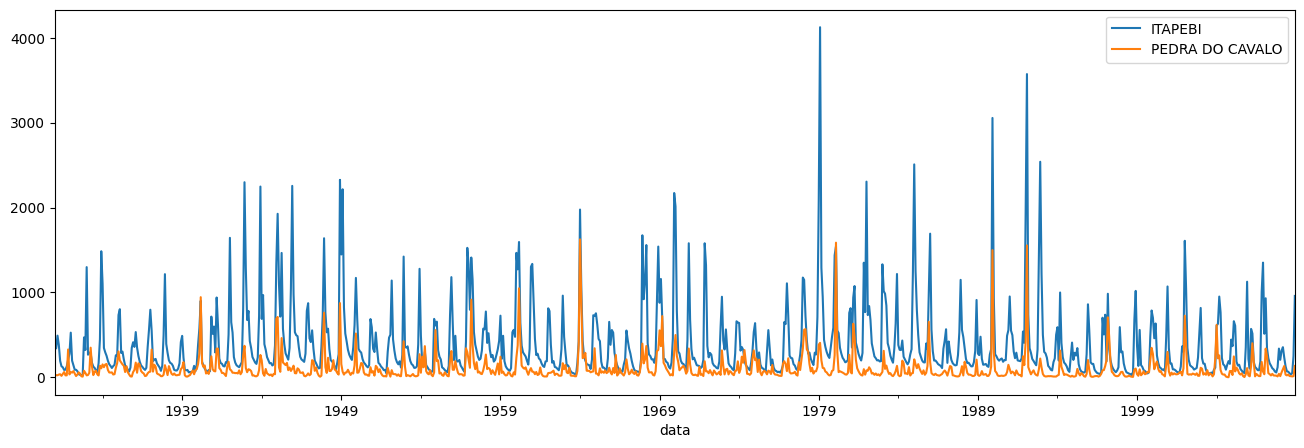

In [9]:
df_filtered[["ITAPEBI", "PEDRA DO CAVALO"]].plot()

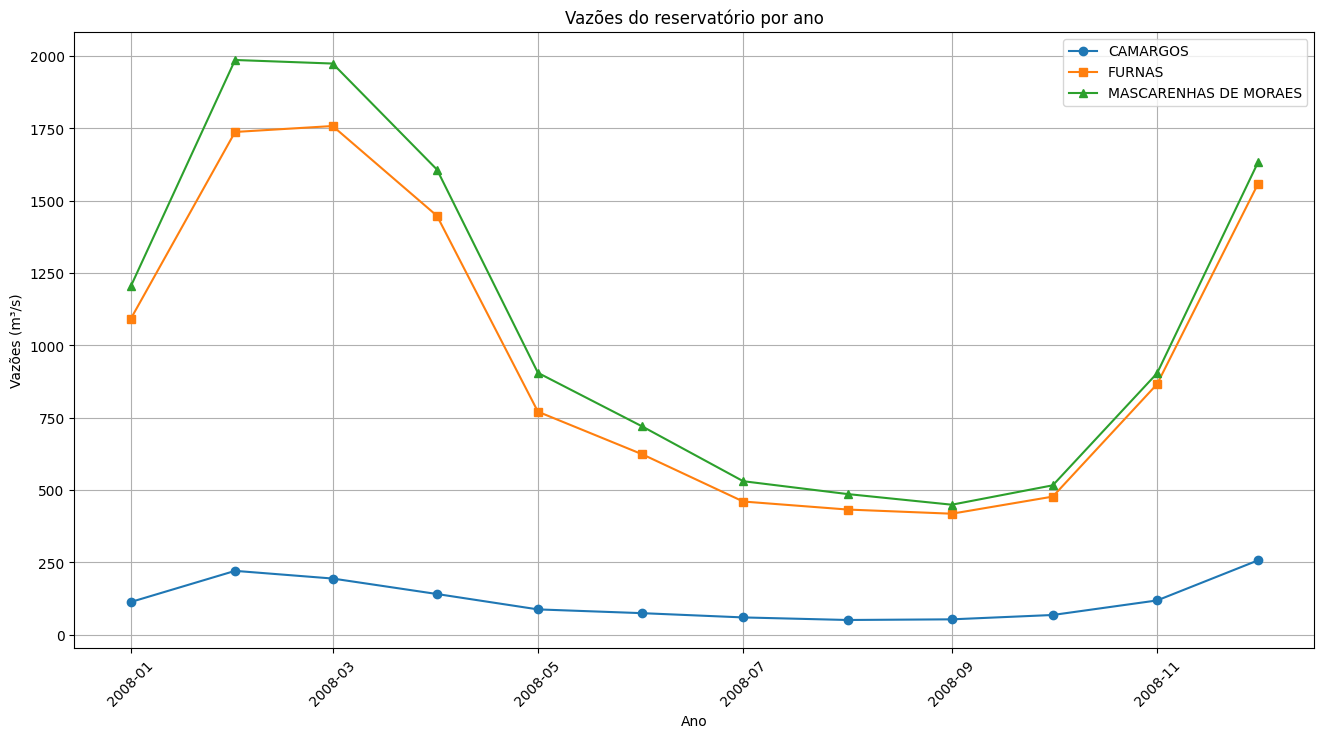

In [10]:
"""
OBS: Visualizando a série diante de uma perspectiva sazonal
Vale lembrar que se trata de vazões de água, ou seja, geralmente iremos ver grandes modificações nos dados durante um certo período do ano. 
A estação das chuvas normalmente vai de Outubro a Abril. Em áreas onde as chuvas estão associadas a mudanças na direcção e velocidade dos ventos,
a estação das chuvas é conhecida como período das monções.
"""
plot_series(df, "2008-12-01", "2008-01-01")

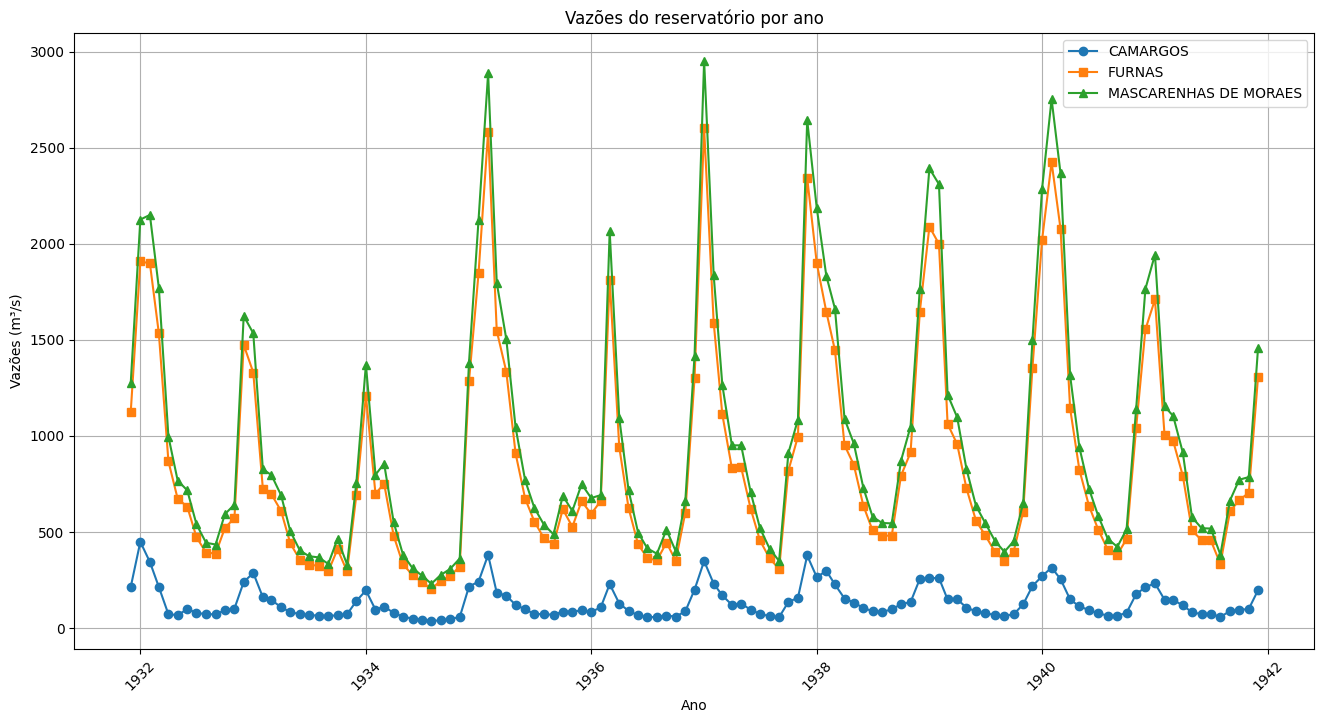

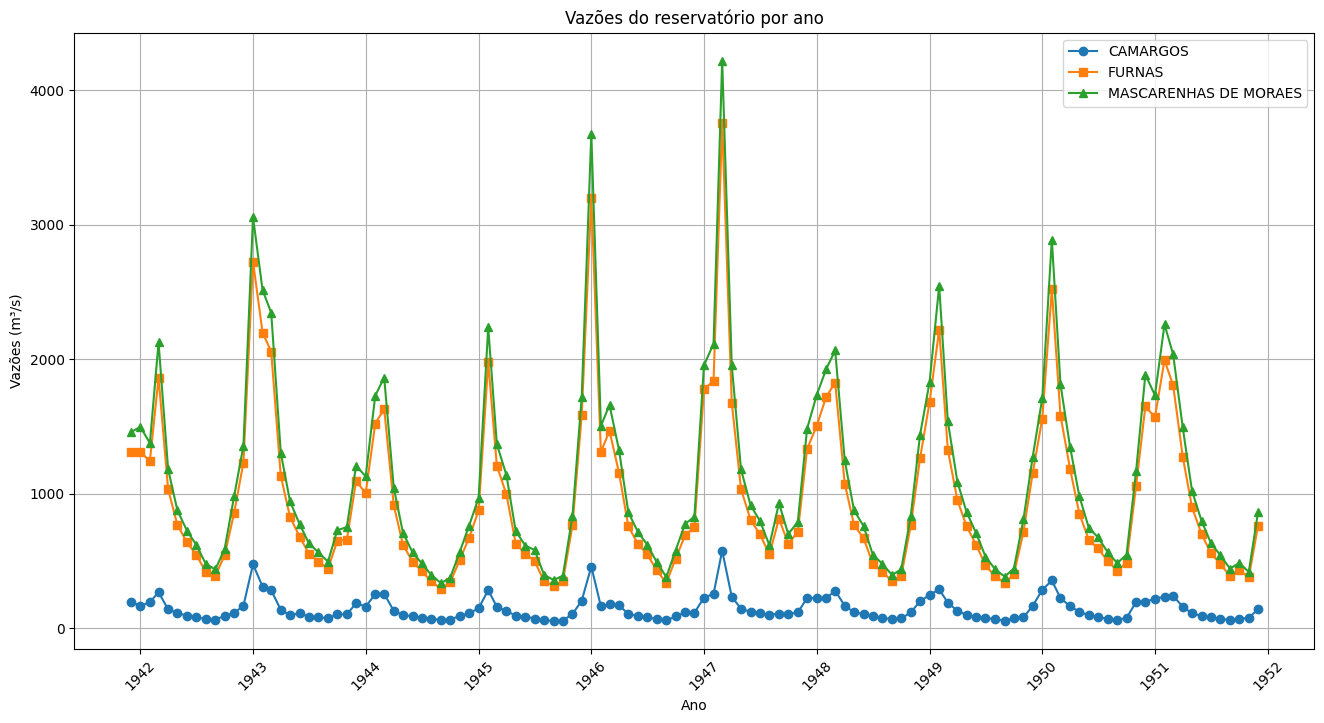

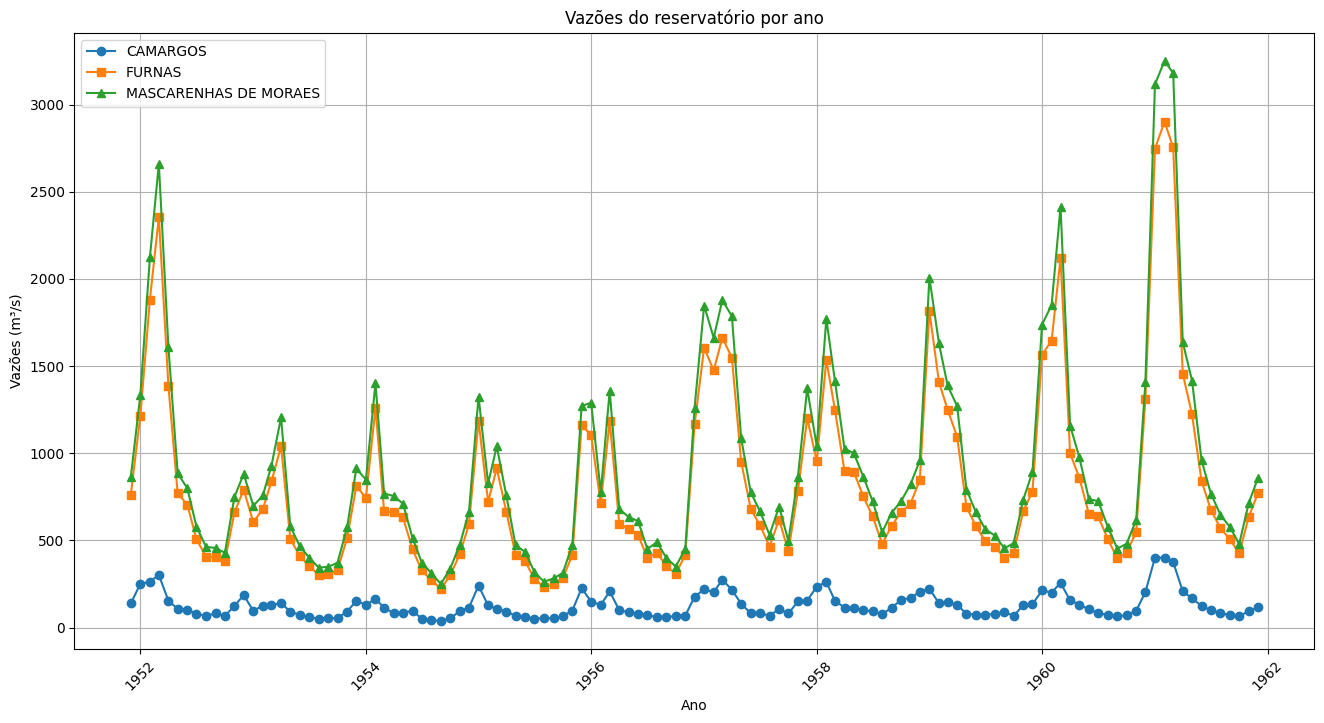

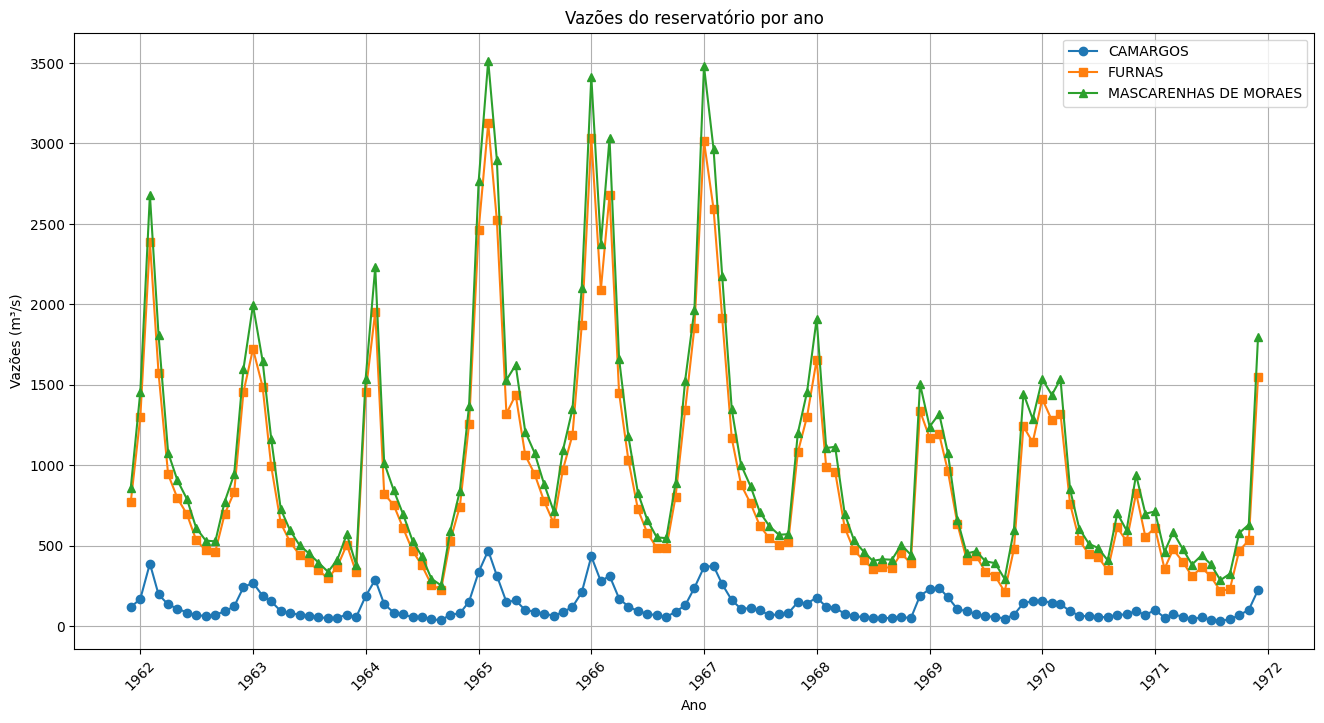

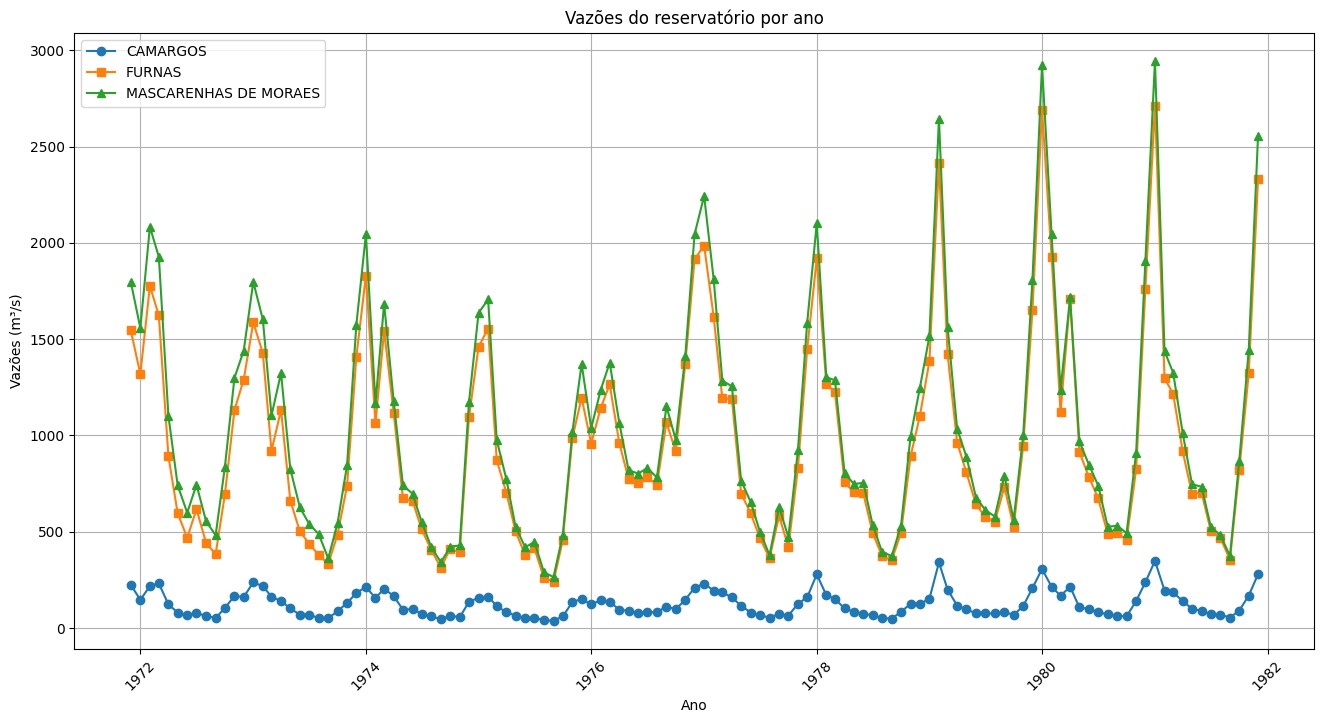

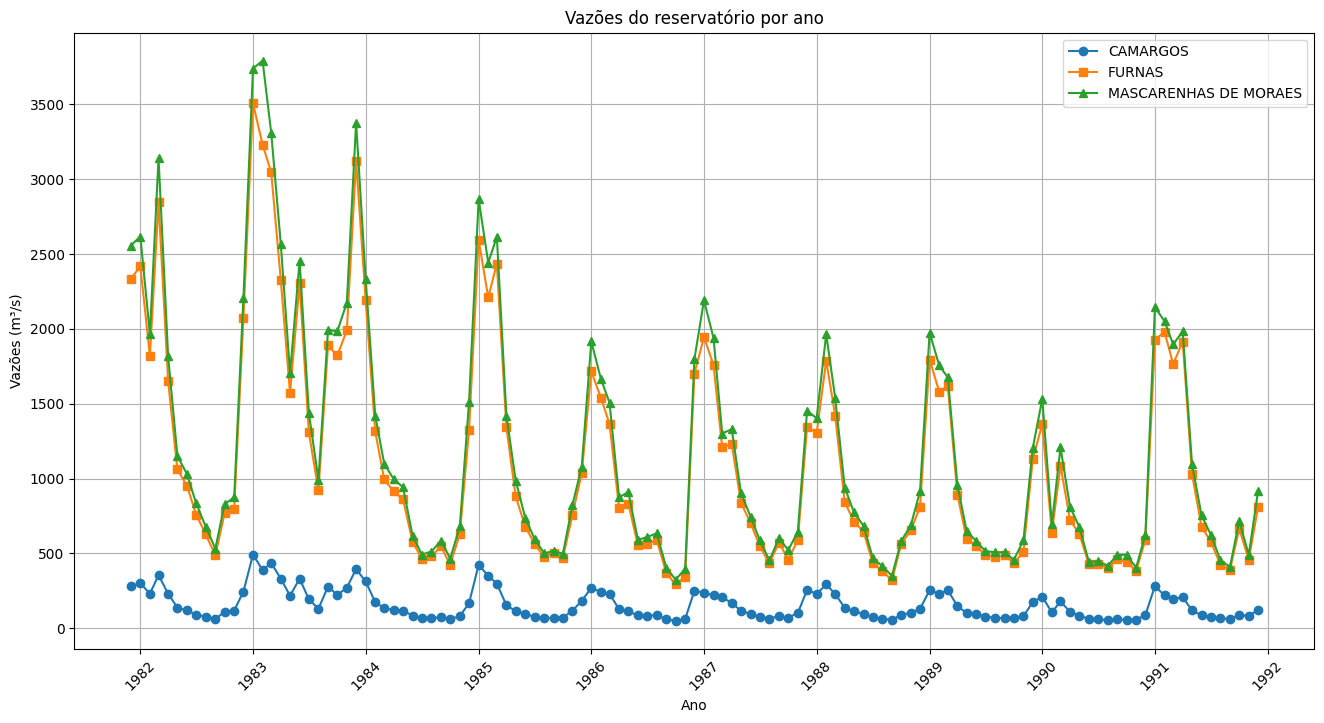

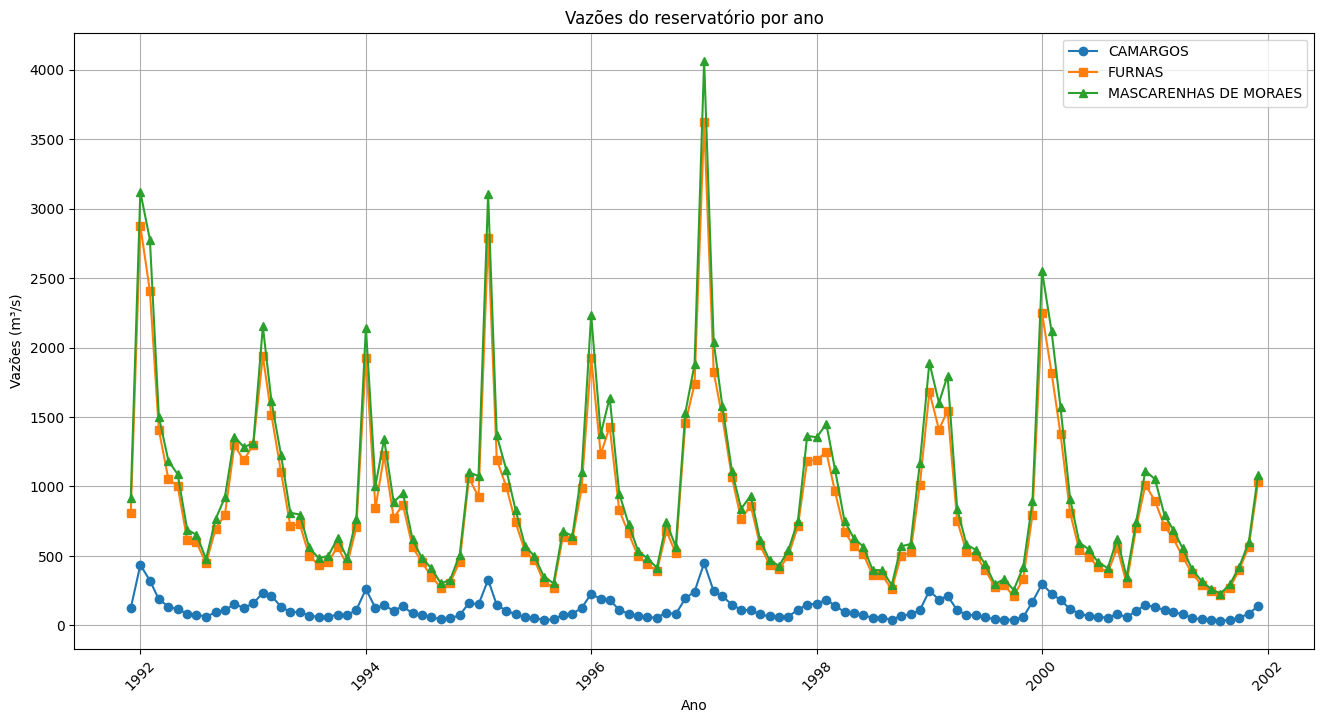

In [11]:
year_period = 10
ranging_list = list(range(1931, 2000+year_period, year_period))
for i, year in enumerate(ranging_list):
    if i == 0: 
        pass
    else:
        plot_series(df, f"{ranging_list[i]}-12-01", f"{ranging_list[i-1]}-12-01")

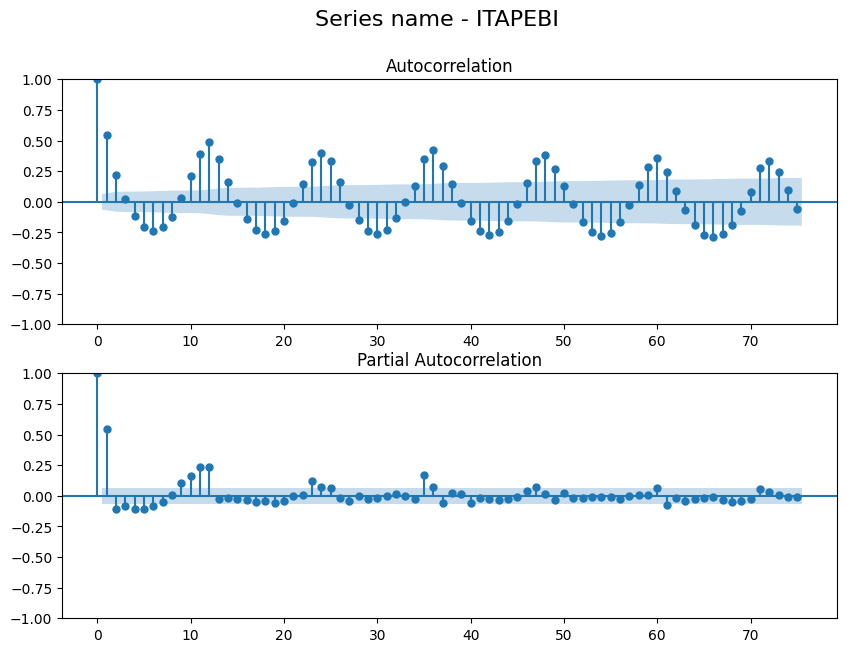

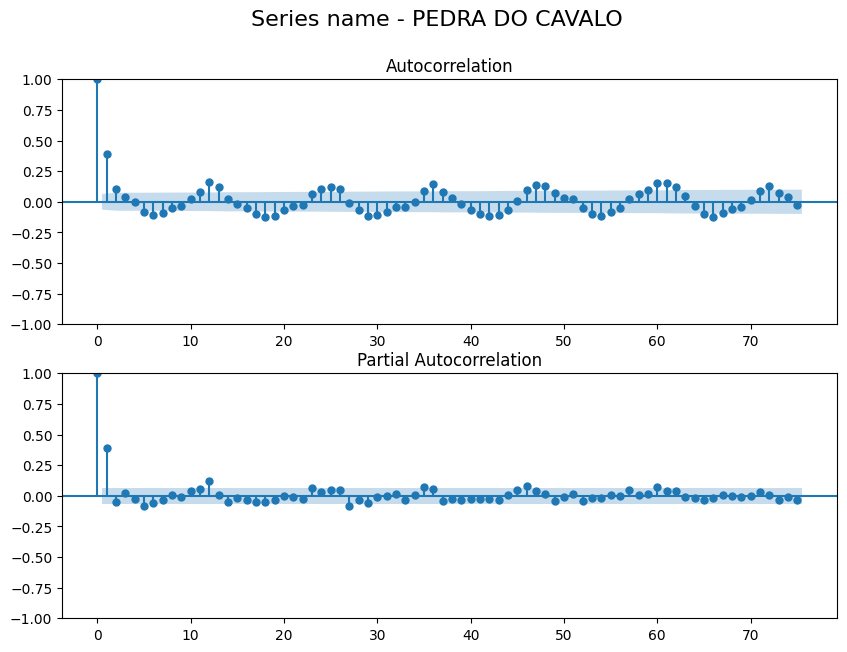

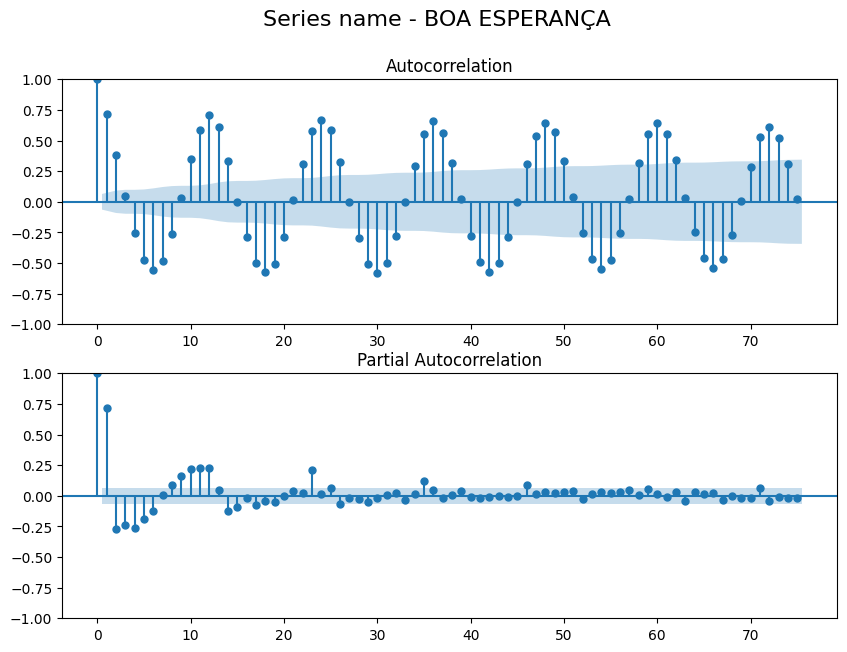

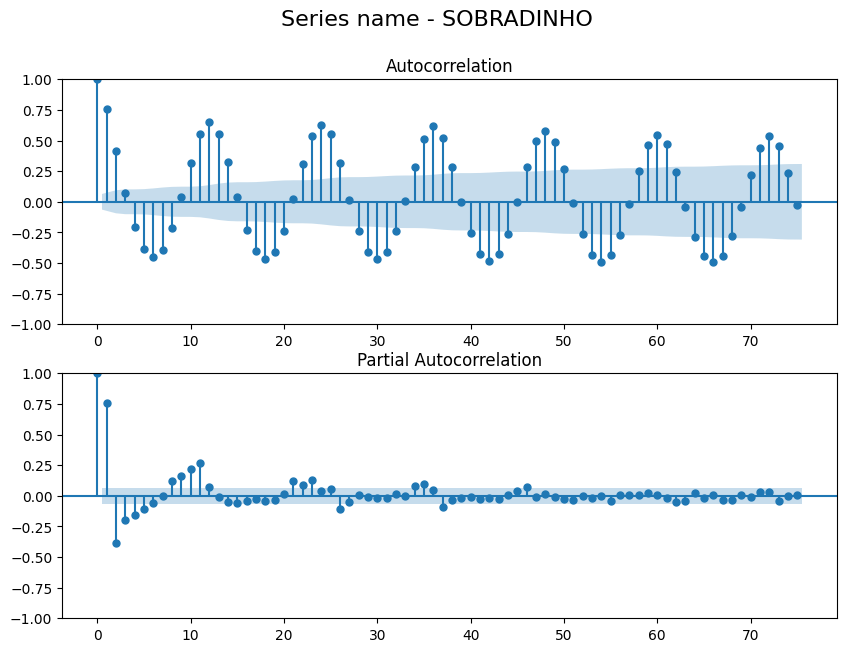

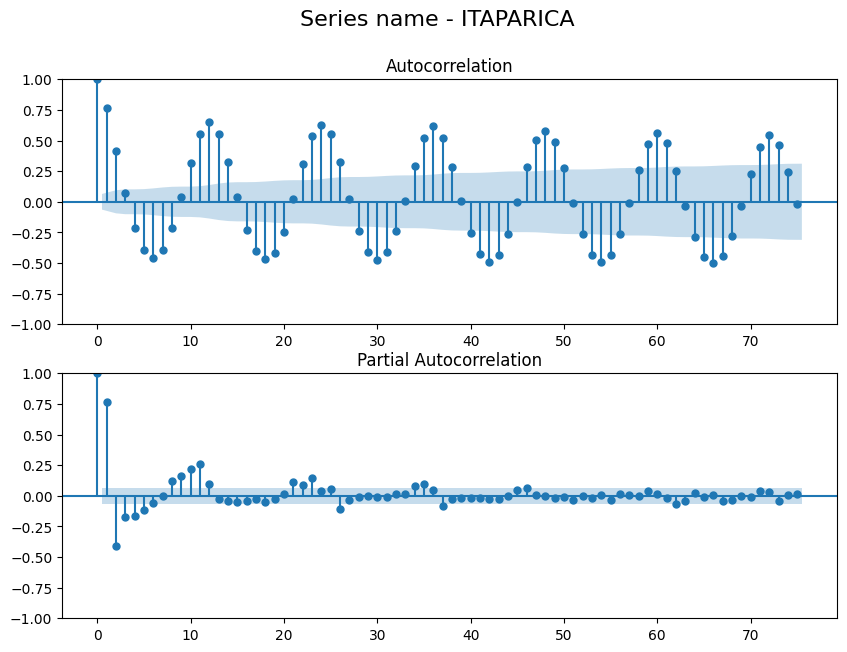

In [22]:
series_names = df_filtered.columns
for series in series_names:
    plot_acf_pacf(df_filtered[series], series)

Ao analisar os gráficos de autocorrelação e autocorrelação parcial, percebe-se que os valores das séries são fortemente sazonais, isso servirá para que possamos setar importantes parâmetros para a predição das séries temporais.

Vale lembrar que é importantíssimo para que possamos afirmar isso, decomposemos a série. Logo abaixo, mostramos também todos as séries decompostas em tendência, sazonal e residual da série.

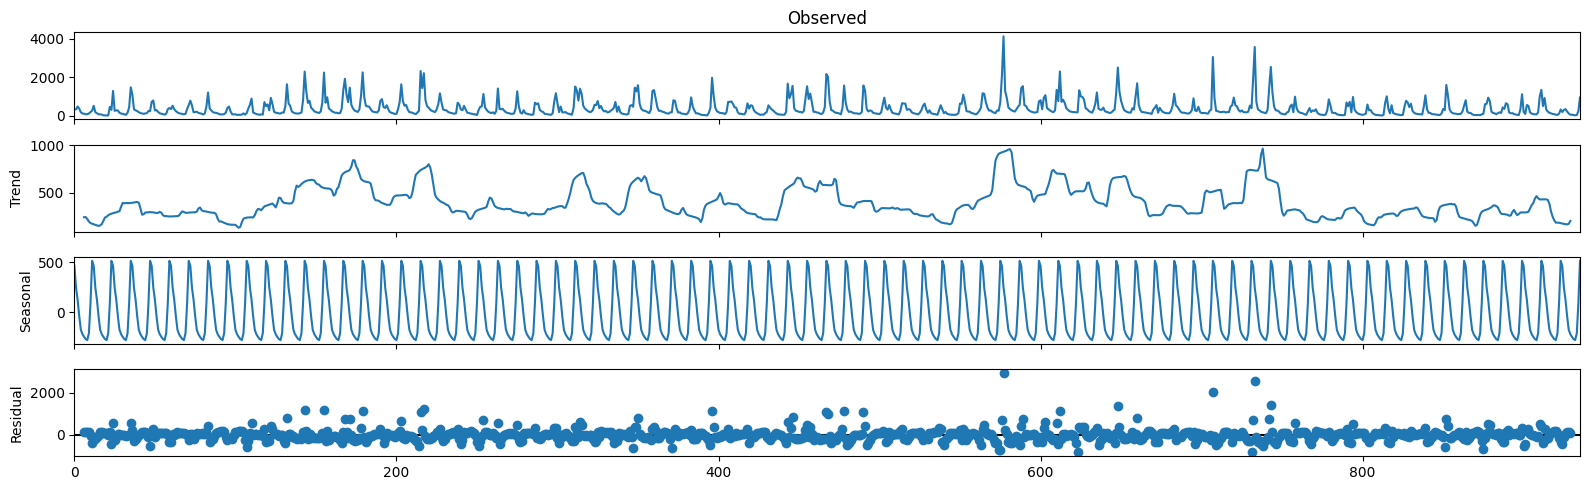

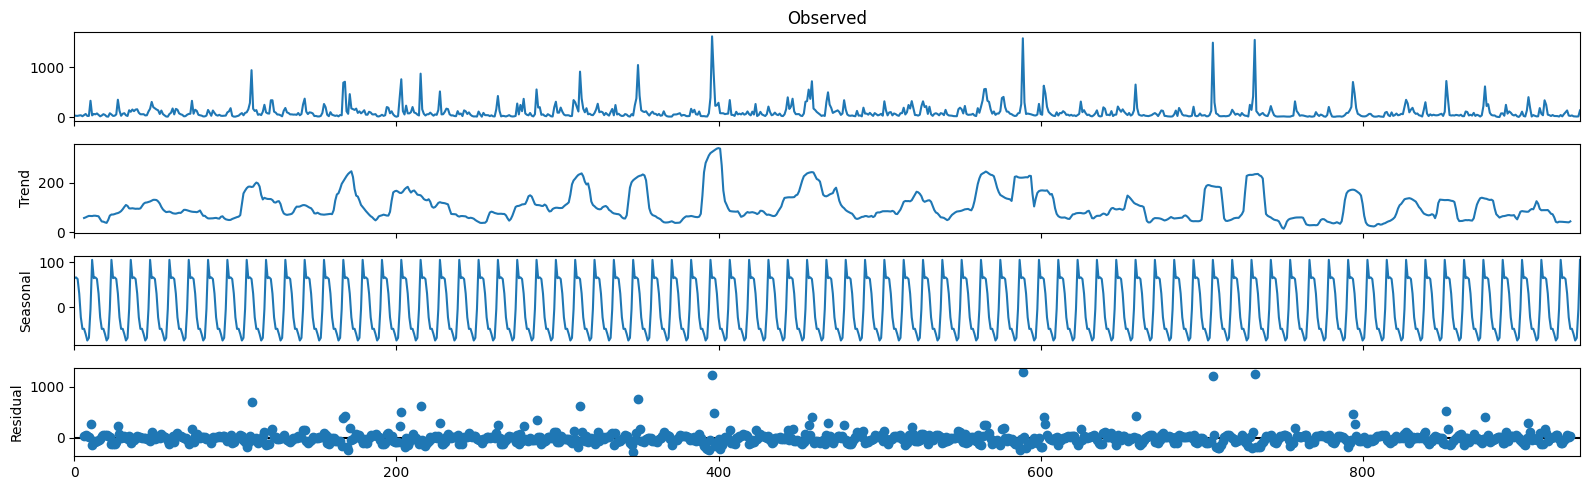

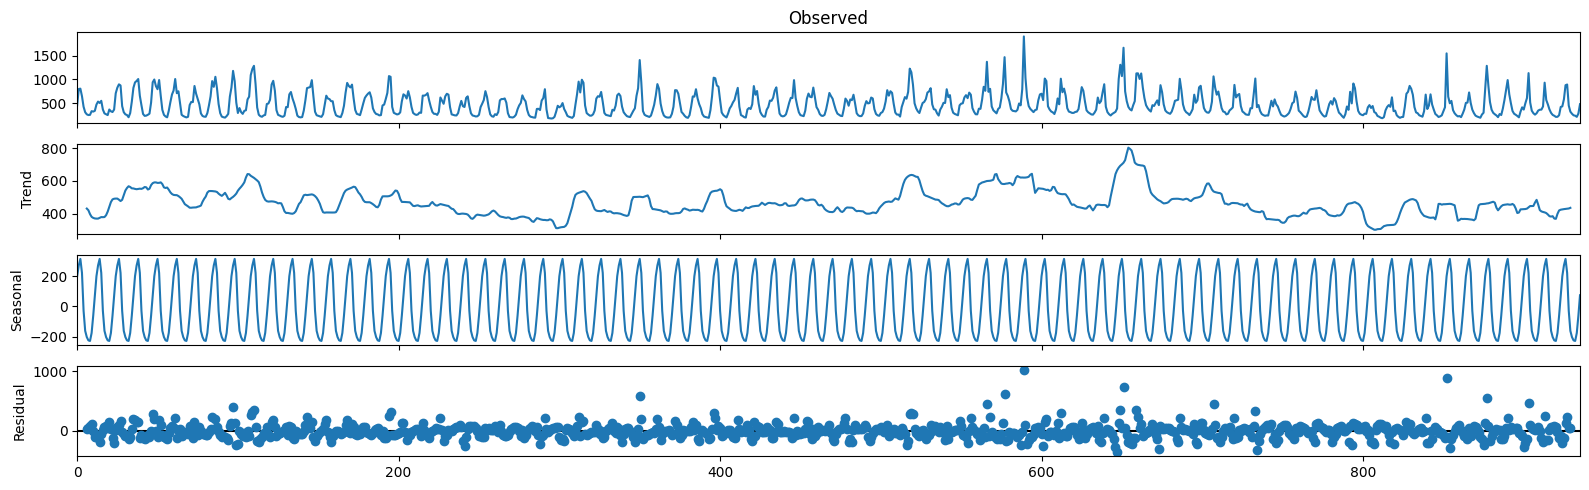

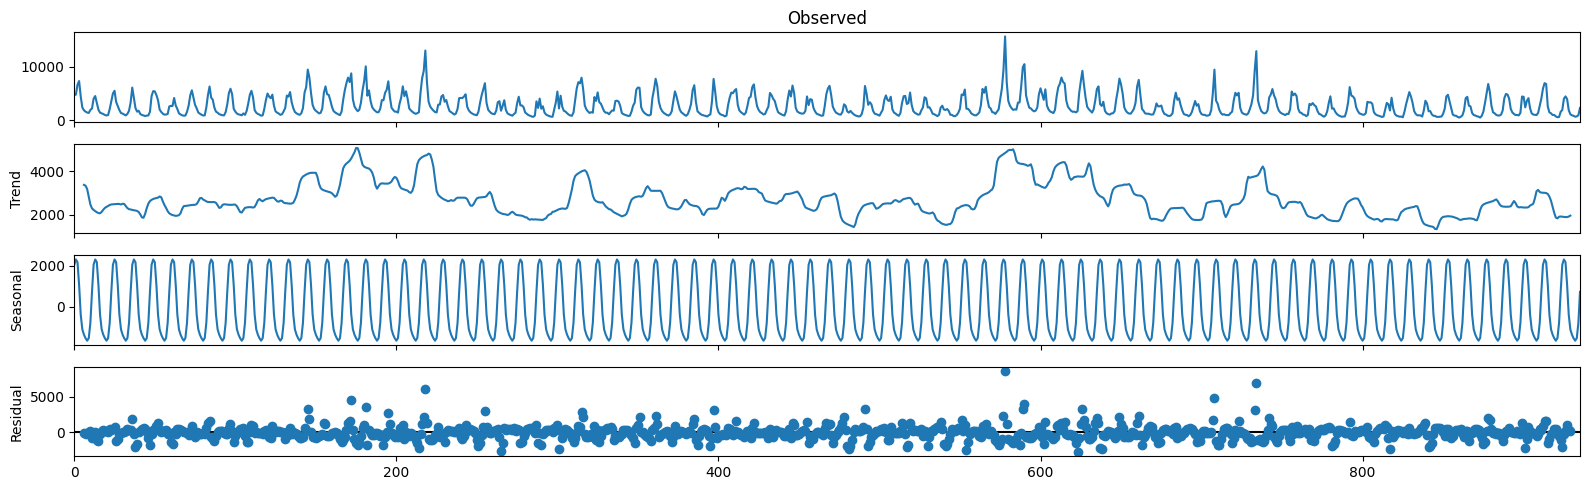

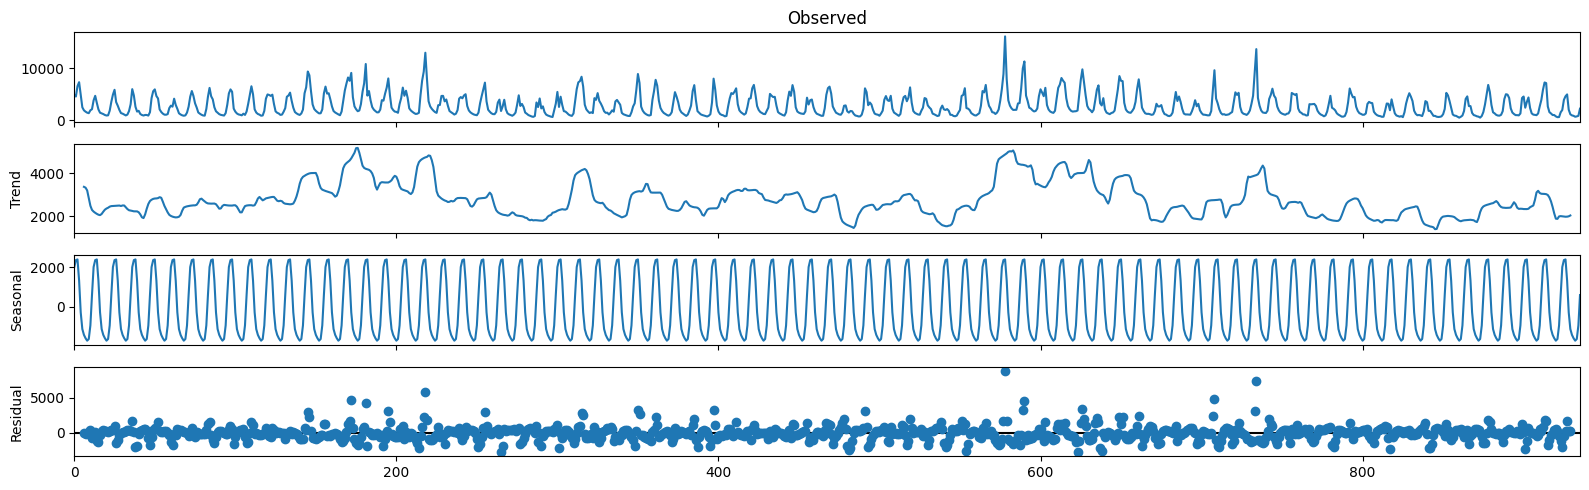

In [ ]:
for series in series_names:
    ts_decompose = seasonal_decompose(np.array(df_filtered[series]), 
                                    model='additive', 
                                    period=12)

    ts_decompose.plot()
    plt.show()

## Escolha do modelo para análise das séries de vazão de cada reservatório

In [20]:
# Mean absolute percentage error of the forecasted sales quantity vs actual values 
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round(np.mean(np.abs((y_true-y_pred)/y_true))*100, )

In [118]:
def plot_results(y, yhat, serie, method):
    # plot expected vs preducted
    plt.plot(y, label='Expected', color='blue')
    plt.plot(yhat, label='Predicted', color='red')
    plt.xlabel("mês")
    plt.ylabel("vazão")
    plt.title(f"Series name - {serie} - Using method {method}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'results/{method}_{serie}.png', bbox_inches='tight')
    plt.show()

## Modelos tradicionais estatísticos

### Arima

In [72]:
# Arima results
arima_results = {}

for series in series_names:
    print(f"Fitting ARIMA for {series}...")
    
    try:
        model = ARIMA(endog=df_filtered[series], order=(1, 0, 0)) 
        results = model.fit()
        arima_results[series] = results
        print(results.summary())
    except Exception as e:
        print(f"Error fitting ARIMA for {series}: {e}")

Fitting ARIMA for ITAPEBI...
                               SARIMAX Results                                
Dep. Variable:                ITAPEBI   No. Observations:                  936
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6853.857
Date:                Sat, 08 Mar 2025   AIC                          13713.715
Time:                        17:42:52   BIC                          13728.240
Sample:                    01-01-1931   HQIC                         13719.253
                         - 12-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        389.2981     43.855      8.877      0.000     303.344     475.252
ar.L1          0.5475      0.015     36.233      0.000       0.518       0.577
sigma2      1.343e+05  

### Sarima

In [73]:
sarima_results = {}

for series in series_names:
    print(f"Fitting SARIMA for {series}...")
    
    try:
        model = SARIMAX(df_filtered[series], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        results = model.fit()
        sarima_results[series] = results
        print(results.summary())
    except Exception as e:
        print(f"Error fitting SARIMA for {series}: {e}")

Fitting SARIMA for ITAPEBI...
                                     SARIMAX Results                                      
Dep. Variable:                            ITAPEBI   No. Observations:                  936
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6645.808
Date:                            Sat, 08 Mar 2025   AIC                          13301.616
Time:                                    17:42:59   BIC                          13325.754
Sample:                                01-01-1931   HQIC                         13310.825
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3883      0.016     23.571      0.000       0.356       0.421
ma.L1

### Prophet

In [40]:
from prophet import Prophet

prophet_results = {}

for series in series_names:
    print(f"Fitting Prophet for {series}...")
    
    try:
        df_prophet = df_filtered[[series]].reset_index().rename(columns={"data": "ds", series: "y"})
        print(df_prophet)
        model = Prophet()
        model.fit(df_prophet)
        prophet_results[series] = model
    except Exception as e:
        print(f"Error fitting Prophet for {series}: {e}")


17:05:17 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for ITAPEBI...
            ds      y
0   1931-01-01  333.0
1   1931-02-01  342.0
2   1931-03-01  491.0
3   1931-04-01  381.0
4   1931-05-01  193.0
..         ...    ...
931 2008-08-01   48.0
932 2008-09-01   34.3
933 2008-10-01   49.4
934 2008-11-01  251.9
935 2008-12-01  958.5

[936 rows x 2 columns]


17:05:17 - cmdstanpy - INFO - Chain [1] done processing
17:05:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for PEDRA DO CAVALO...
            ds      y
0   1931-01-01   32.0
1   1931-02-01   25.0
2   1931-03-01   24.0
3   1931-04-01   32.0
4   1931-05-01   36.0
..         ...    ...
931 2008-08-01   14.9
932 2008-09-01   13.5
933 2008-10-01   10.5
934 2008-11-01   13.7
935 2008-12-01  134.0

[936 rows x 2 columns]


17:05:18 - cmdstanpy - INFO - Chain [1] done processing
17:05:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for BOA ESPERANÇA...
            ds      y
0   1931-01-01  452.0
1   1931-02-01  796.0
2   1931-03-01  804.0
3   1931-04-01  644.0
4   1931-05-01  421.0
..         ...    ...
931 2008-08-01  240.7
932 2008-09-01  232.5
933 2008-10-01  207.6
934 2008-11-01  278.7
935 2008-12-01  475.5

[936 rows x 2 columns]


17:05:18 - cmdstanpy - INFO - Chain [1] done processing
17:05:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for SOBRADINHO...
            ds       y
0   1931-01-01  4676.0
1   1931-02-01  4805.0
2   1931-03-01  6630.0
3   1931-04-01  7333.0
4   1931-05-01  4467.0
..         ...     ...
931 2008-08-01   843.0
932 2008-09-01   669.0
933 2008-10-01   729.0
934 2008-11-01   945.0
935 2008-12-01  2303.0

[936 rows x 2 columns]


17:05:18 - cmdstanpy - INFO - Chain [1] done processing
17:05:18 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet for ITAPARICA...
            ds       y
0   1931-01-01  4870.0
1   1931-02-01  4550.0
2   1931-03-01  6537.0
3   1931-04-01  7298.0
4   1931-05-01  4942.0
..         ...     ...
931 2008-08-01   851.0
932 2008-09-01   674.0
933 2008-10-01   742.0
934 2008-11-01   853.0
935 2008-12-01  2223.0

[936 rows x 2 columns]


17:05:18 - cmdstanpy - INFO - Chain [1] done processing


#### Selecionando parâmetros do modelo ARIMA (p,q,m) de maneira automática com o pmdarima:

Função de autocorrelação (ACF): ajuda a determinar q.

Função Parcial de autocorrelação (PACF): ajuda a determinar p.

Teste Dickey-Fuller Aumentado (ADF) test: Determina d verificando se é necessário diferenciar.


In [ ]:
best_arima_models = {}

for series in df_filtered.columns:
    print(f"Finding best ARIMA for {series}...")
    
    try:
        model = pm.auto_arima(df_filtered[series], 
                              seasonal=True,  # Set True if seasonality is strong
                              stepwise=True, 
                              trace=True,
                              m=12)  # Shows progress
        
        best_arima_models[series] = model
        print(f"Best ARIMA for {series}: {model.order}")
    except Exception as e:
        print(f"Error selecting ARIMA for {series}: {e}")


In [41]:
arima_results = {}

for series, best_model in best_arima_models.items():
    print(f"Fitting ARIMA {best_model.order} for {series}...")
    
    try:
        model = ARIMA(df_filtered[series], order=best_model.order)
        results = model.fit()
        arima_results[series] = results
        print(results.summary())
    except Exception as e:
        print(f"Error fitting ARIMA for {series}: {e}")

Fitting ARIMA (1, 0, 0) for ITAPEBI...
                               SARIMAX Results                                
Dep. Variable:                ITAPEBI   No. Observations:                  936
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6853.857
Date:                Sat, 08 Mar 2025   AIC                          13713.715
Time:                        17:05:33   BIC                          13728.240
Sample:                    01-01-1931   HQIC                         13719.253
                         - 12-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        389.2981     43.855      8.877      0.000     303.344     475.252
ar.L1          0.5475      0.015     36.233      0.000       0.518       0.577
sigma2      1

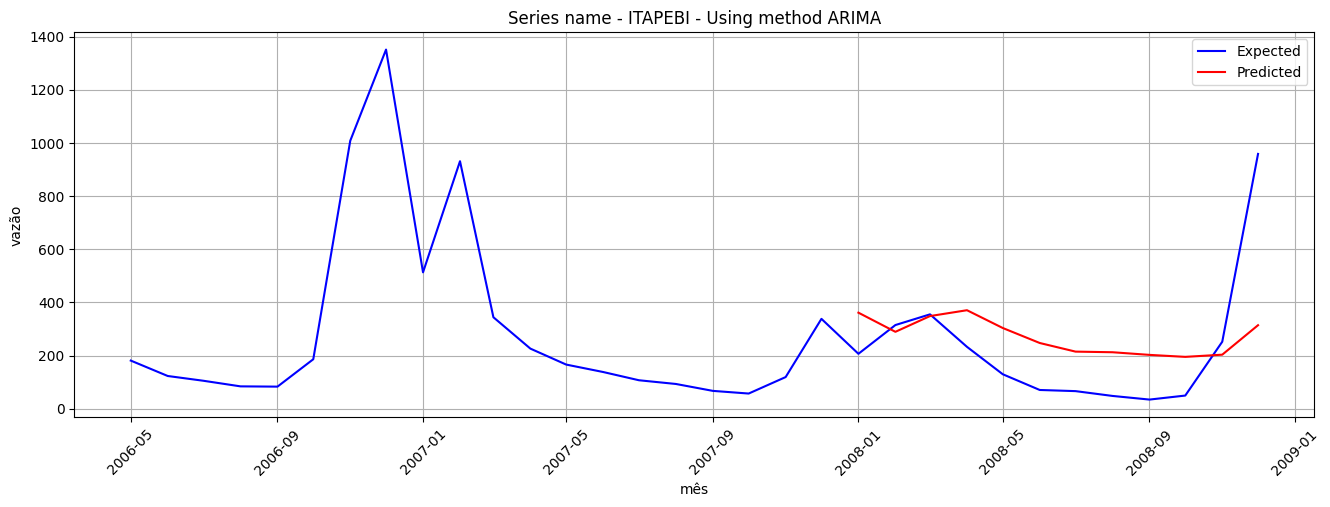

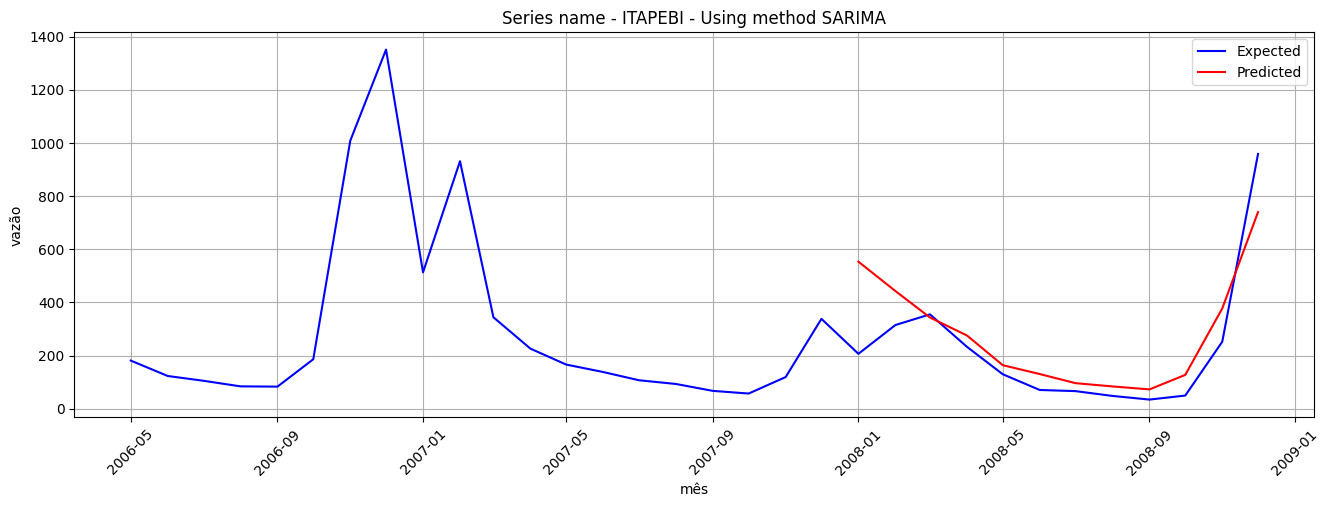

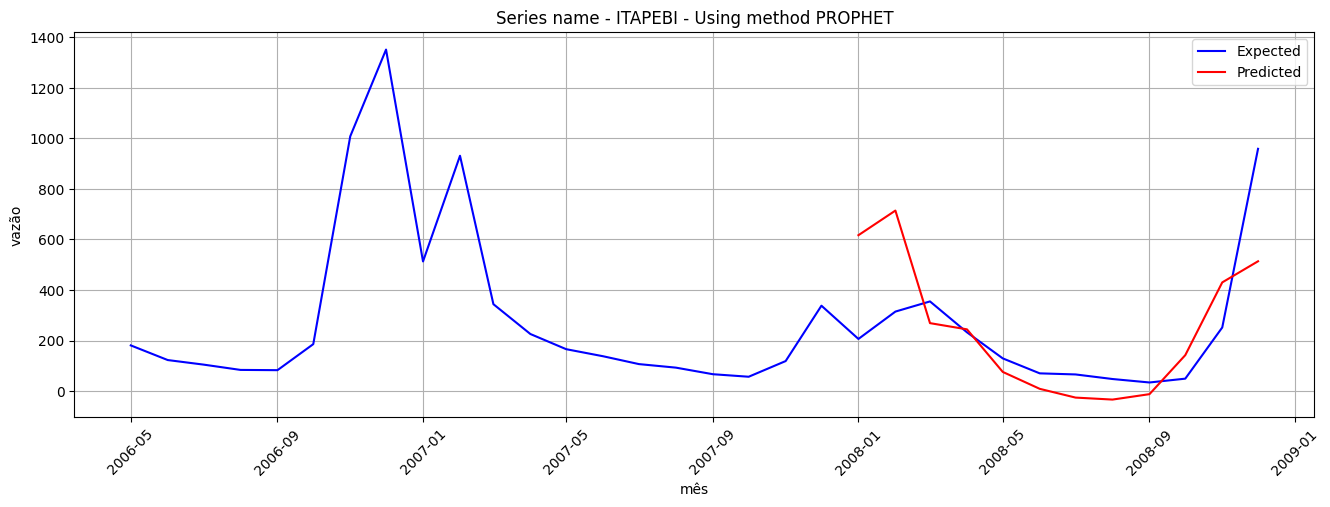

----------------- ITAPEBI - RMSE: -----------------
ARIMA: 227.5430
SARIMA: 134.3039
PROPHET: 223.1447


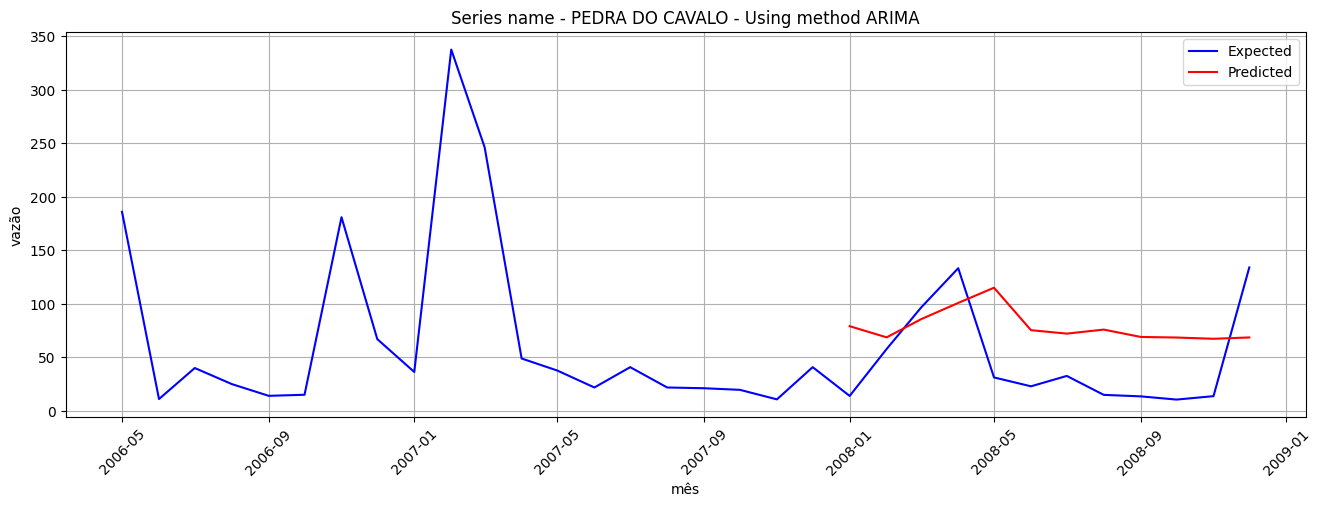

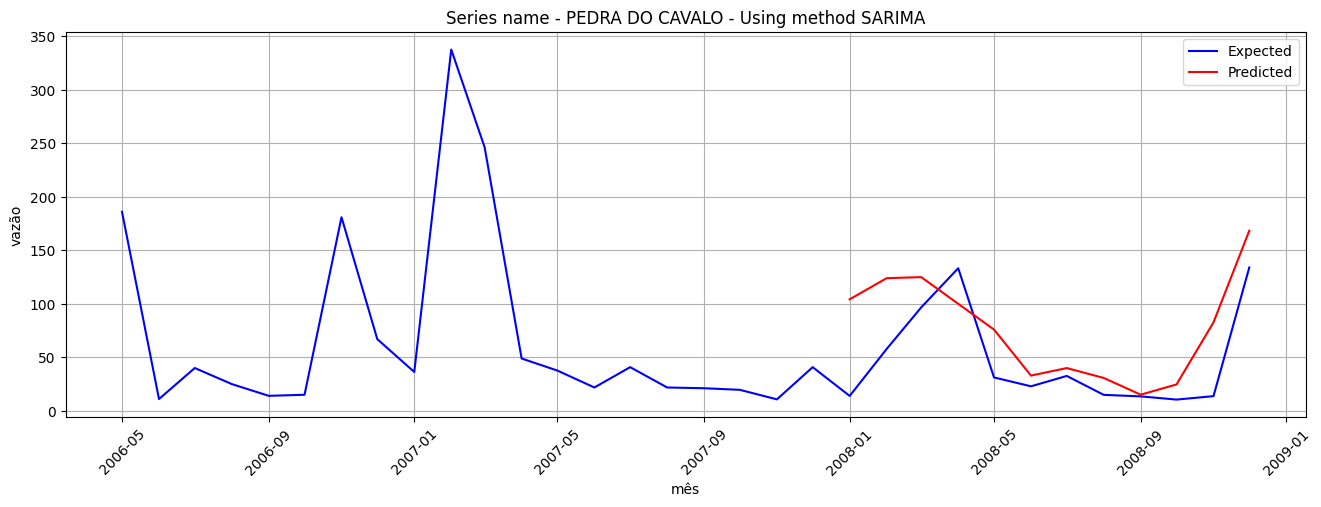

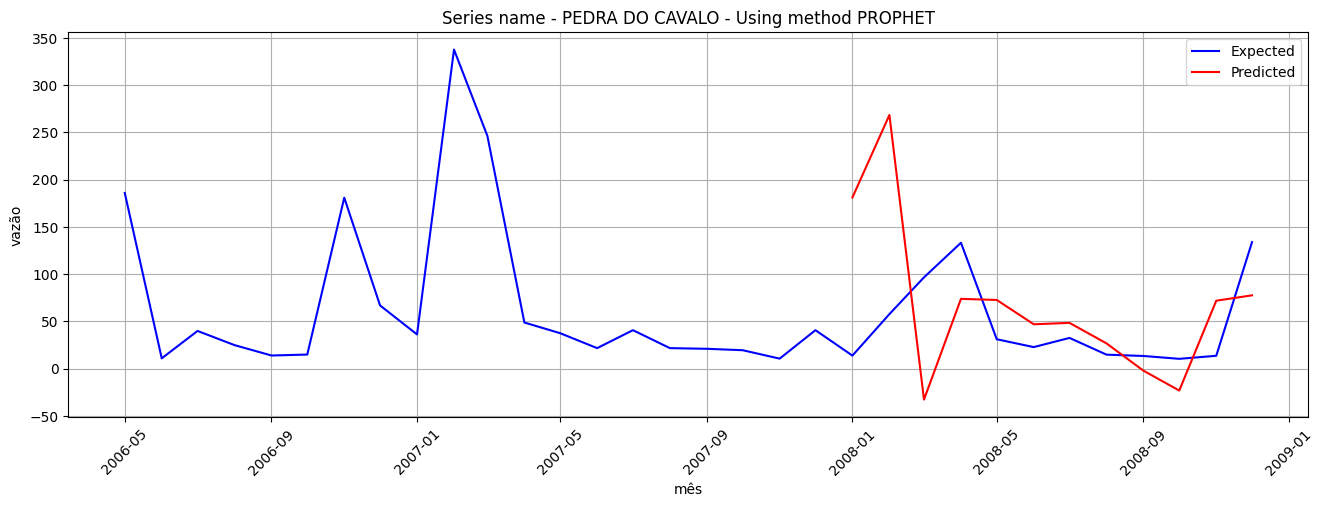

----------------- PEDRA DO CAVALO - RMSE: -----------------
ARIMA: 53.4094
SARIMA: 43.7768
PROPHET: 92.7650


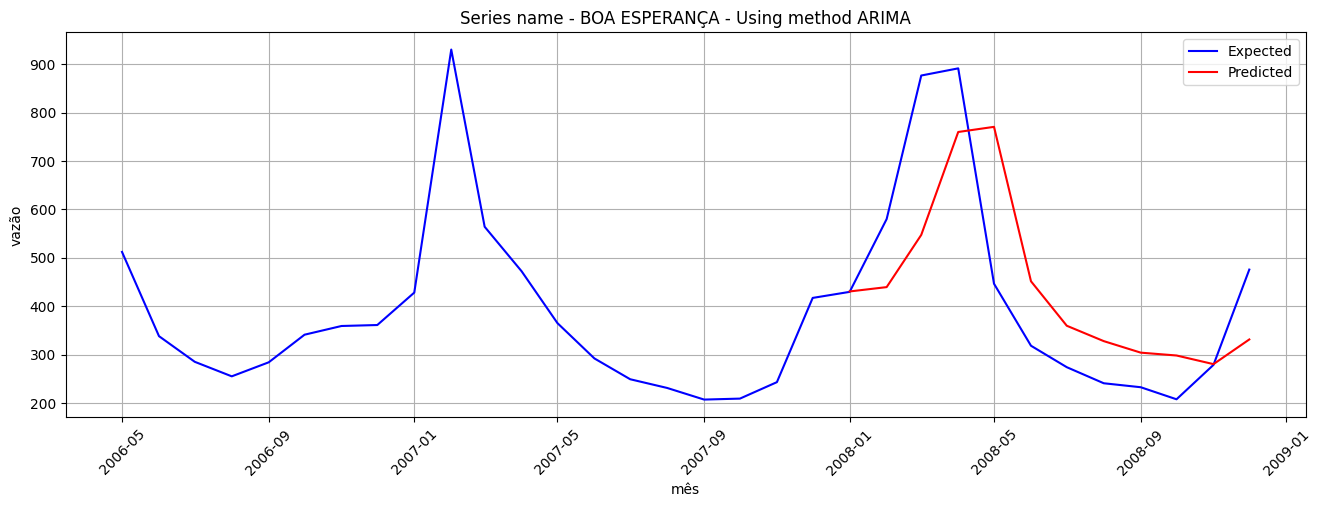

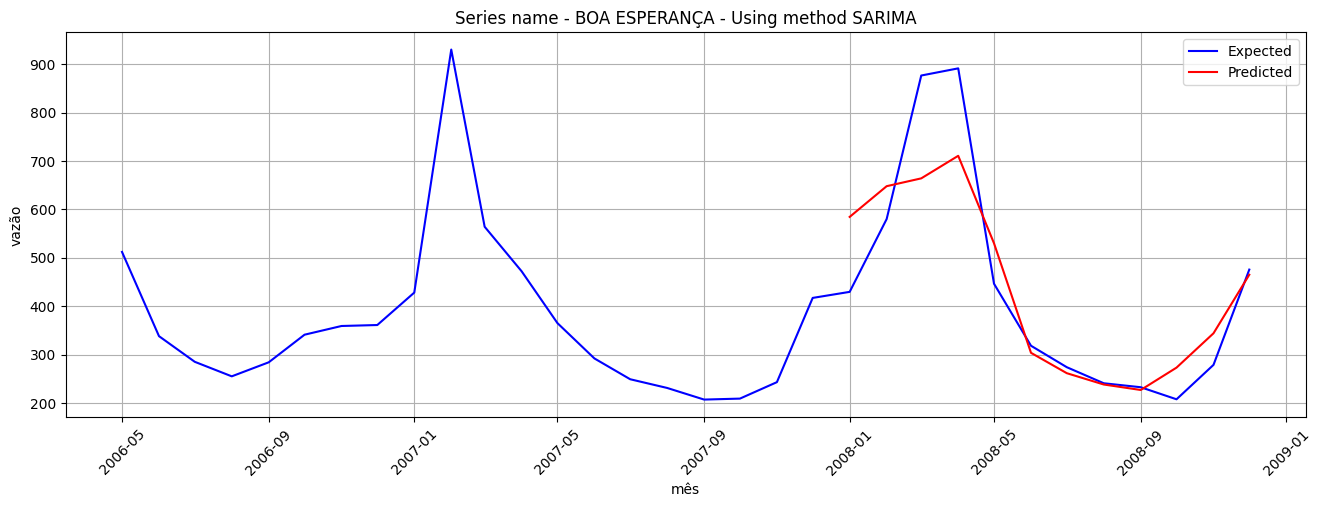

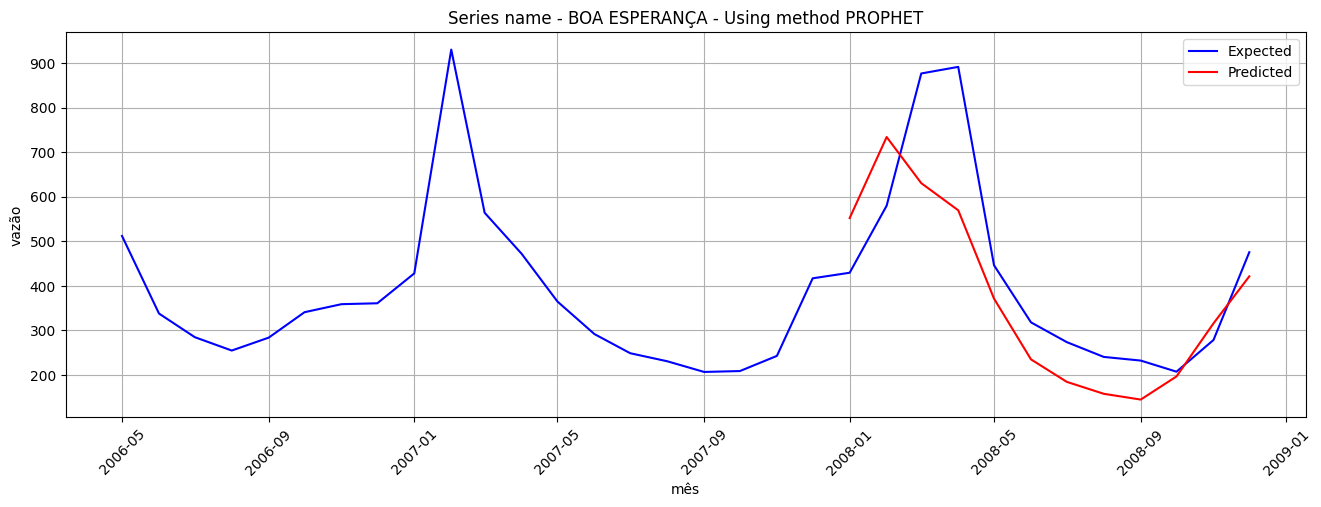

----------------- BOA ESPERANÇA - RMSE: -----------------
ARIMA: 162.5877
SARIMA: 100.9848
PROPHET: 142.0214


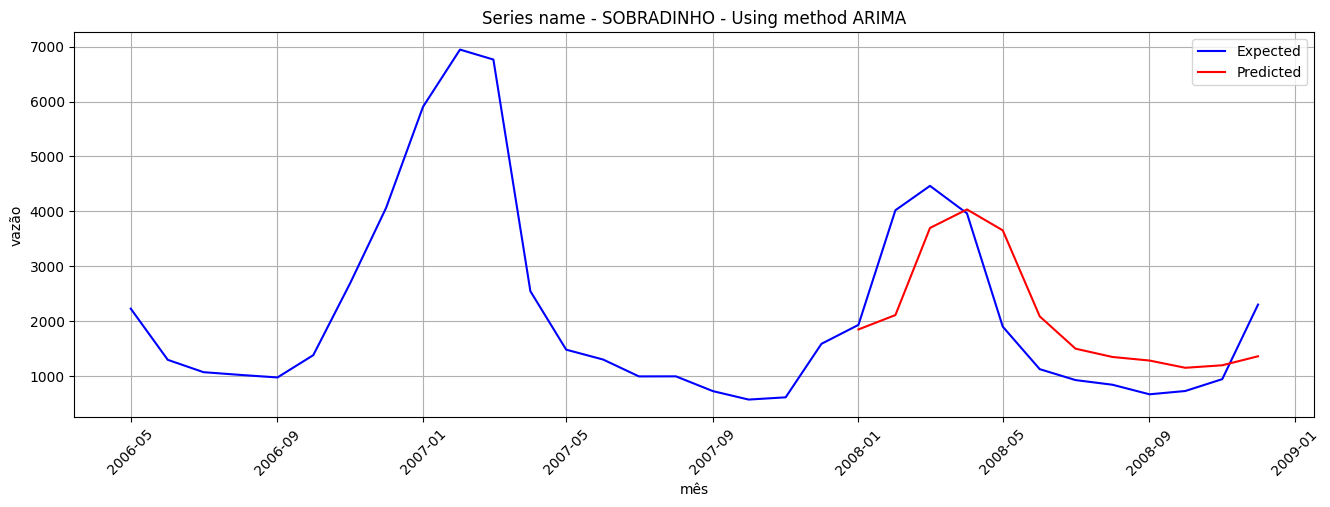

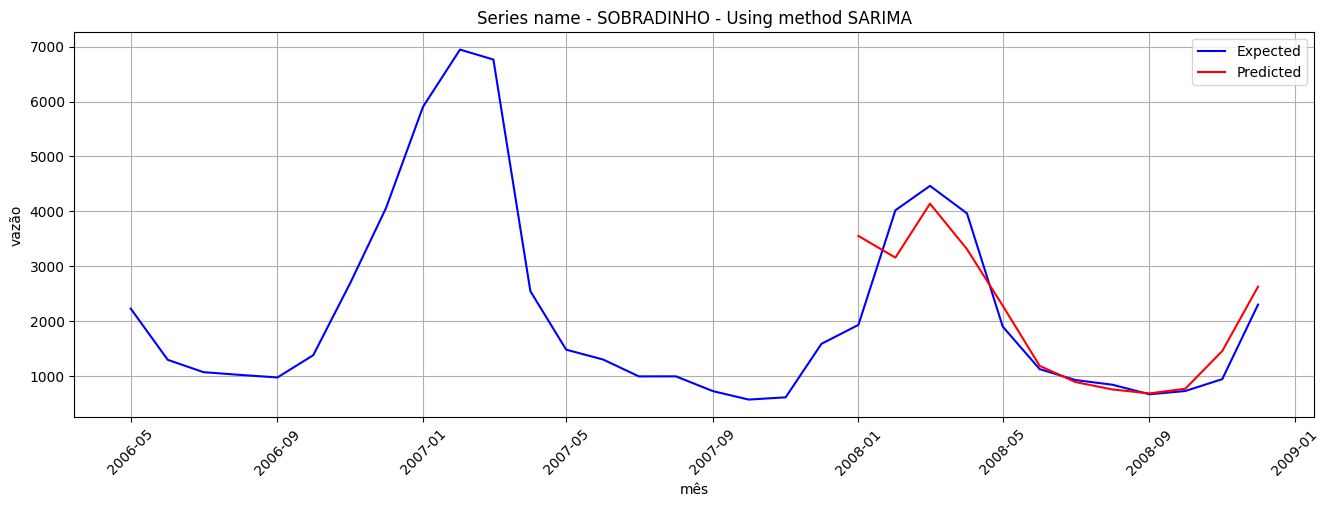

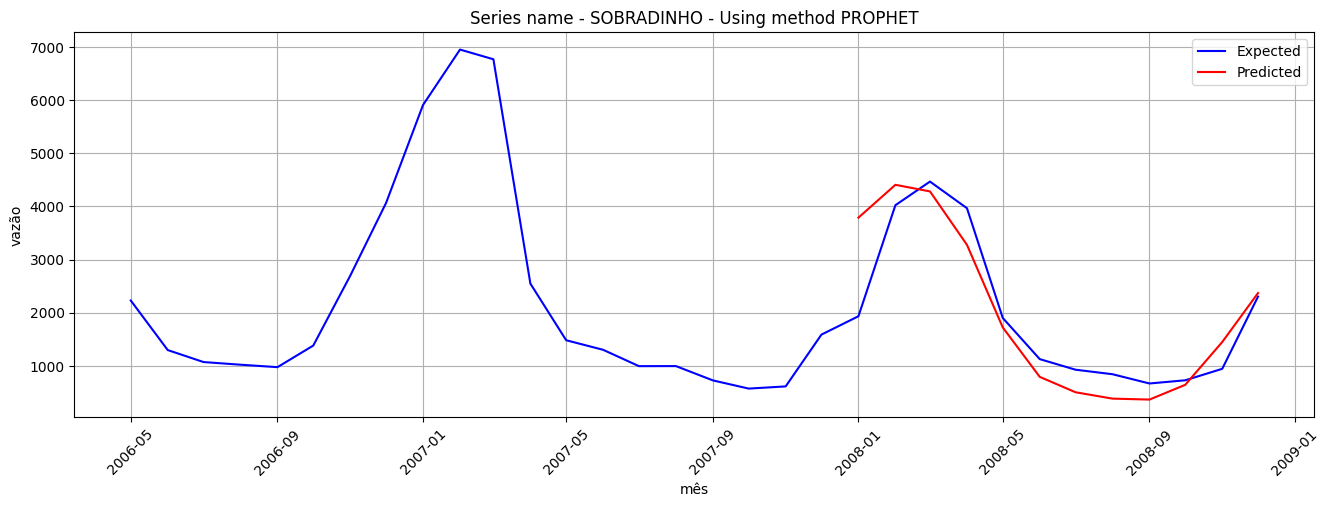

----------------- SOBRADINHO - RMSE: -----------------
ARIMA: 927.9493
SARIMA: 607.1646
PROPHET: 644.3868


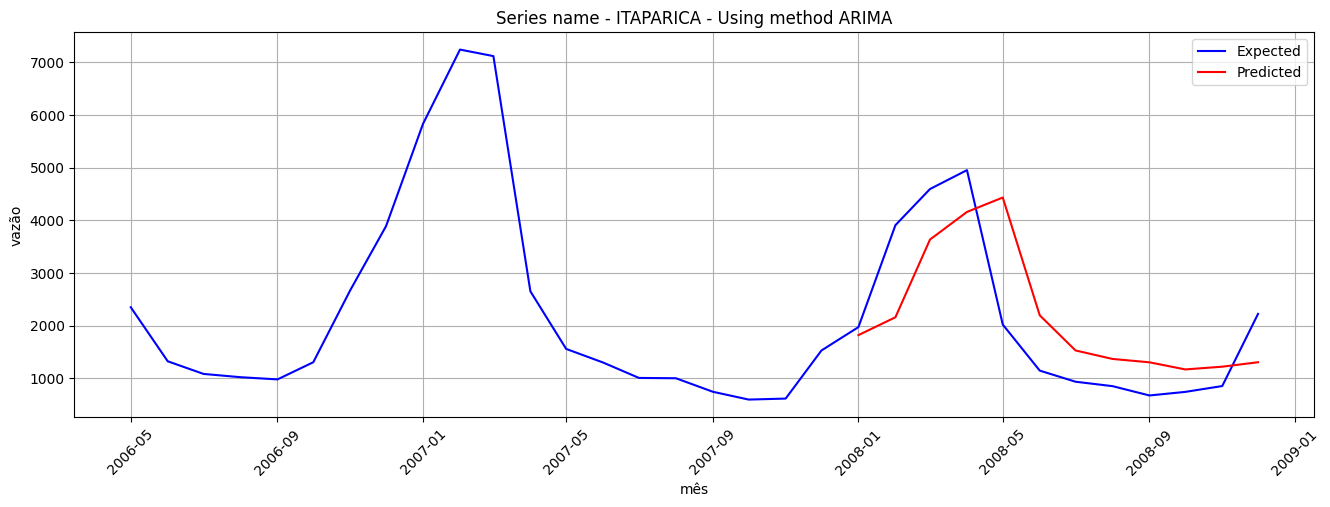

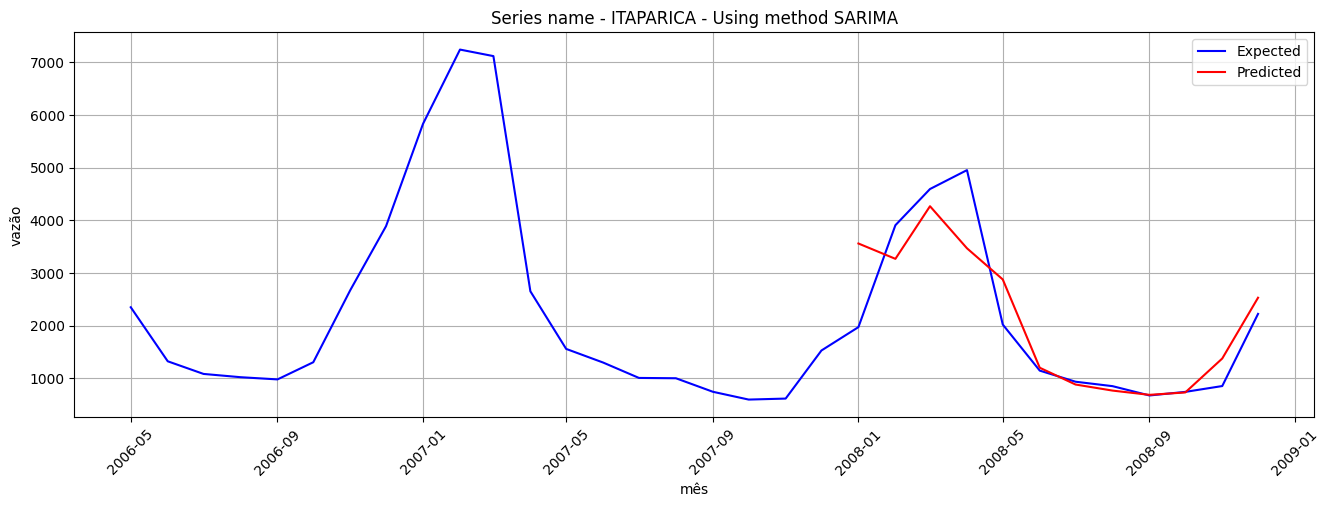

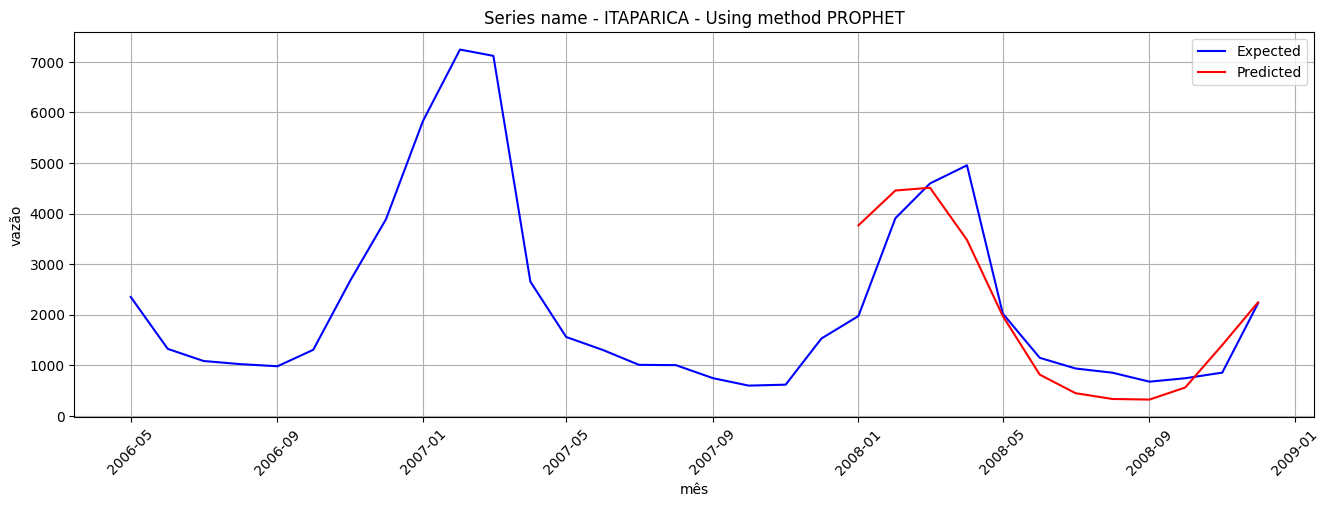

----------------- ITAPARICA - RMSE: -----------------
ARIMA: 1069.4489
SARIMA: 727.5521
PROPHET: 751.5424


In [119]:
def predict(future_steps, start_date="2008-01-01"):
    for series in series_names:
        actual = df_filtered[series].iloc[-future_steps:]
        actual_plot = df_filtered[series].iloc[-32:]
        #arima_pred = arima_results[series].forecast(steps=12)
        
        end_date = df_filtered.index.max()
        # Get the in-sample predictions for the training data
        arima_pred = arima_results[series].predict(start=start_date, end=end_date, typ='levels')
        sarima_pred = sarima_results[series].predict(start=start_date, end=end_date, typ='levels')
        
        # Generate future dataframe for Prophet
        future = prophet_results[series].make_future_dataframe(periods=future_steps, freq='M')
        prophet_pred = prophet_results[series].predict(future)
        
        # Extract only the predicted values for the next 12 periods
        prophet_pred_values = prophet_pred['yhat'].iloc[-future_steps:]
        forecast_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')
        prophet_pred = pd.Series(prophet_pred_values.values, index=forecast_dates)

        rmse_arima = root_mean_squared_error(actual, arima_pred)
        rmse_sarima = root_mean_squared_error(actual, sarima_pred)
        rmse_prophet = root_mean_squared_error(actual, prophet_pred)

        plot_results(actual_plot, arima_pred, series, method="ARIMA")
        plot_results(actual_plot, sarima_pred, series, method="SARIMA")
        plot_results(actual_plot, prophet_pred, series, method="PROPHET")
        
        print(f"----------------- {series} - RMSE: -----------------")
        print(f"ARIMA: {rmse_arima:.4f}")
        print(f"SARIMA: {rmse_sarima:.4f}")
        print(f"PROPHET: {rmse_prophet:.4f}")

predict(12)

## Modelos baseados em árvores

XGBOOST REGRESSOR

In [120]:
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]

def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	mae = mean_absolute_error(test[:, -1], predictions)
	rmse = root_mean_squared_error(test[:, -1], predictions)
	mape = get_mape(test[:, -1], predictions)
	return mae, rmse, mape, test[:, -1], predictions # -12-24 = -36 (3 anos)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	#n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

expected=206.5, predicted=392.1
expected=314.7, predicted=661.1
expected=354.9, predicted=219.1
expected=232.7, predicted=320.0
expected=129.6, predicted=346.6
expected=70.4, predicted=127.4
expected=66.1, predicted=73.8
expected=48.0, predicted=133.8
expected=34.3, predicted=-9.9
expected=49.4, predicted=-10.1
expected=251.9, predicted=173.1
expected=958.5, predicted=683.5
----------------- ITAPEBI -----------------
MAE: 131.666
RMSE: 164.711
MAPE: 85.000


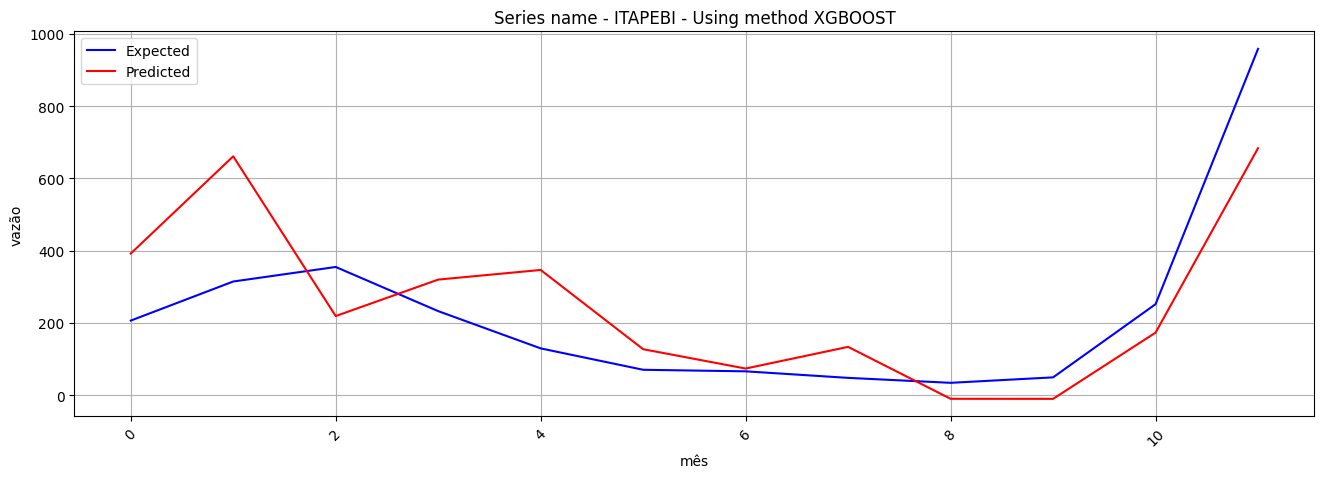

----------------------------------
expected=13.9, predicted=57.4
expected=57.8, predicted=99.9
expected=96.7, predicted=185.4
expected=133.3, predicted=265.6
expected=31.2, predicted=109.5
expected=22.9, predicted=51.0
expected=32.6, predicted=12.8
expected=14.9, predicted=58.4
expected=13.5, predicted=-8.5
expected=10.5, predicted=45.5
expected=13.7, predicted=230.2
expected=134.0, predicted=20.4
----------------- PEDRA DO CAVALO -----------------
MAE: 71.955
RMSE: 91.174
MAPE: 289.000


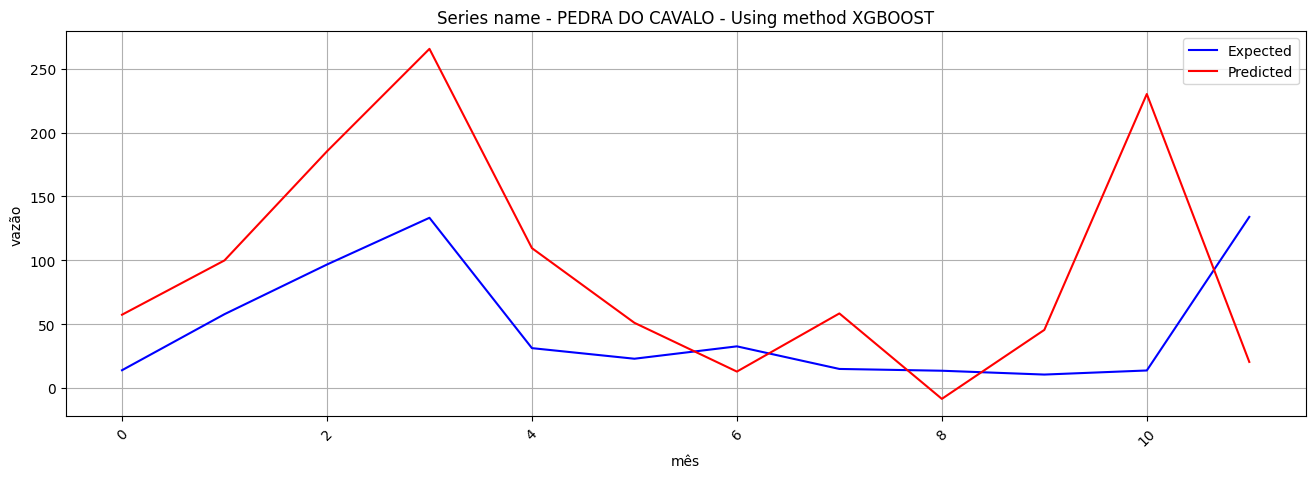

----------------------------------
expected=429.5, predicted=468.8
expected=579.9, predicted=645.2
expected=876.4, predicted=587.9
expected=891.2, predicted=707.3
expected=446.3, predicted=724.7
expected=318.2, predicted=314.8
expected=273.9, predicted=284.2
expected=240.7, predicted=268.5
expected=232.5, predicted=237.5
expected=207.6, predicted=245.0
expected=278.7, predicted=298.9
expected=475.5, predicted=450.5
----------------- BOA ESPERANÇA -----------------
MAE: 82.031
RMSE: 130.295
MAPE: 15.000


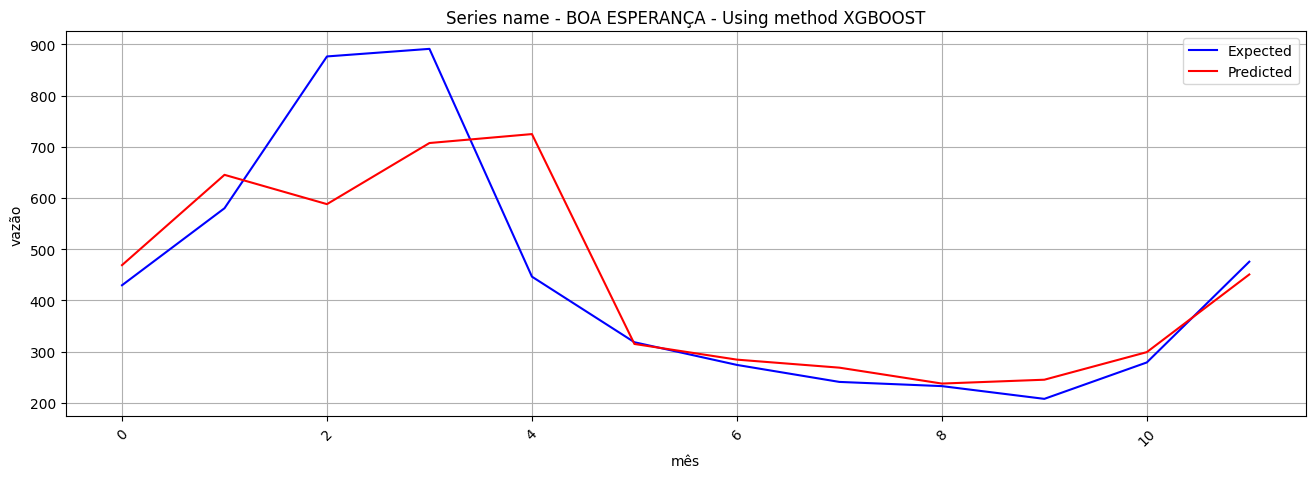

----------------------------------
expected=1933.0, predicted=2817.7
expected=4021.0, predicted=3504.4
expected=4465.0, predicted=4319.0
expected=3964.0, predicted=3061.2
expected=1901.0, predicted=2913.5
expected=1127.0, predicted=1876.3
expected=928.0, predicted=1176.3
expected=843.0, predicted=879.0
expected=669.0, predicted=574.0
expected=729.0, predicted=677.6
expected=945.0, predicted=790.4
expected=2303.0, predicted=2121.9
----------------- SOBRADINHO -----------------
MAE: 414.867
RMSE: 548.033
MAPE: 23.000


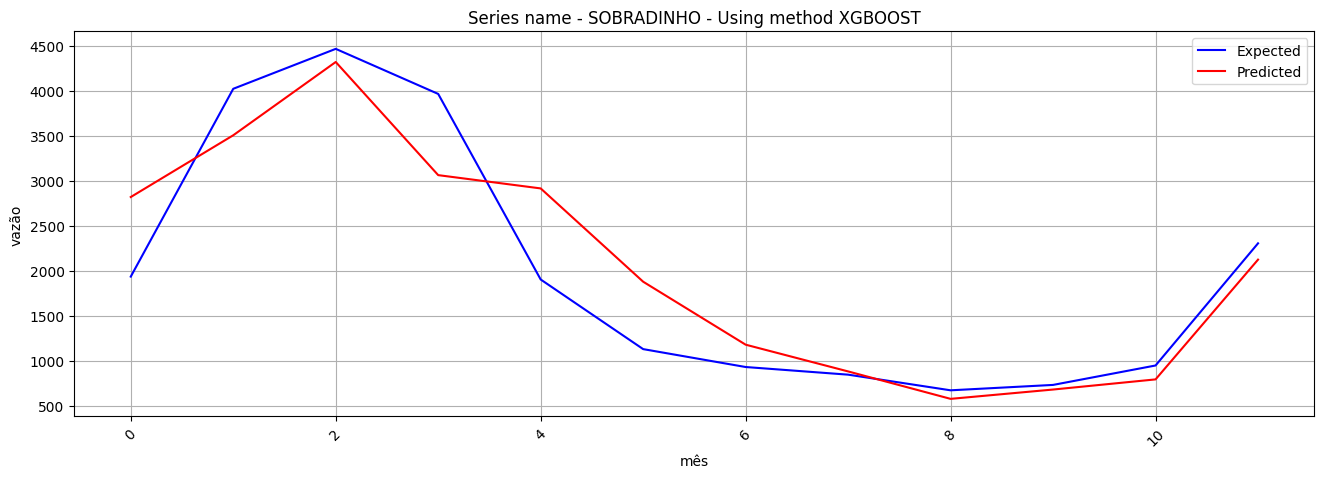

----------------------------------
expected=1972.0, predicted=2848.9
expected=3907.0, predicted=4296.8
expected=4594.0, predicted=4203.8
expected=4953.0, predicted=4442.6
expected=2021.0, predicted=3981.6
expected=1146.0, predicted=1507.5
expected=935.0, predicted=847.8
expected=851.0, predicted=898.5
expected=674.0, predicted=762.4
expected=742.0, predicted=585.6
expected=853.0, predicted=847.0
expected=2223.0, predicted=1410.4
----------------- ITAPARICA -----------------
MAE: 473.945
RMSE: 707.743
MAPE: 24.000


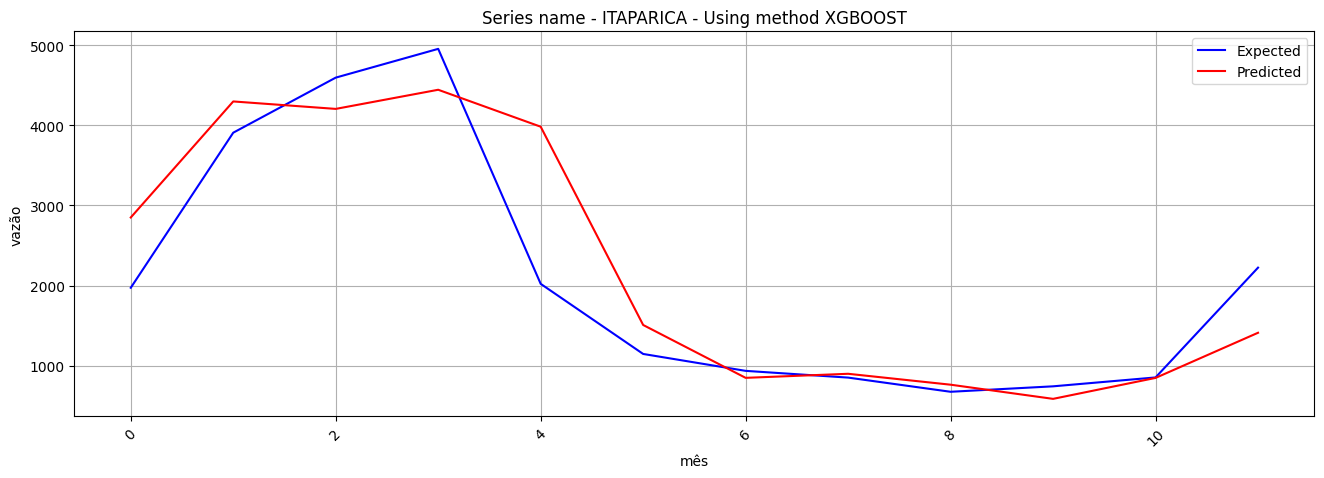

----------------------------------


In [121]:
def predict_tree(future_step=12):
    for serie in series_names:
        values = df_filtered[serie].values

        # transform the time series data into supervised learning
        data = series_to_supervised(values, n_in=6)
        # evaluate
        mae, rmse, mape, y, yhat = walk_forward_validation(data, future_step)
        print(f"----------------- {serie} -----------------")
        print('MAE: %.3f' % mae)
        print('RMSE: %.3f' % rmse)
        print('MAPE: %.3f' % mape)
        plot_results(y, yhat, serie, method="XGBOOST")
        print(f"----------------------------------")

predict_tree()

## Modelos baseados em redes neurais

LSTM

In [109]:
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for serie in series_names:
    data = df_filtered[[serie]]

    # Normalize data (LSTMs perform better with scaled data)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Convert to supervised learning format
    def create_sequences(data, time_steps=12):
        X, y = [], []
        for i in range(len(data) - time_steps - 12):  
            X.append(data[i : i + time_steps])
            y.append(data[i + time_steps : i + time_steps + 12])
        return np.array(X), np.array(y)

    time_steps = 12
    X, y = create_sequences(data_scaled, time_steps)

    # Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    X_train_dict[serie] = X_train
    X_test_dict[serie] = X_test
    y_train_dict[serie] = y_train
    y_test_dict[serie] = y_test

    print("Training shape:", X_train.shape, y_train.shape)
    print("Testing shape:", X_test.shape, y_test.shape)

Training shape: (729, 12, 1) (729, 12, 1)
Testing shape: (183, 12, 1) (183, 12, 1)
Training shape: (729, 12, 1) (729, 12, 1)
Testing shape: (183, 12, 1) (183, 12, 1)
Training shape: (729, 12, 1) (729, 12, 1)
Testing shape: (183, 12, 1) (183, 12, 1)
Training shape: (729, 12, 1) (729, 12, 1)
Testing shape: (183, 12, 1) (183, 12, 1)
Training shape: (729, 12, 1) (729, 12, 1)
Testing shape: (183, 12, 1) (183, 12, 1)


In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def lstm_model(time_steps):
    # Define LSTM model
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(time_steps, 1)),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(12)
    ])

    # Compile the model
    model.compile(optimizer="adam", loss="mse")
    return model

Treinando para a série: ITAPEBI
1/1 [==============================] - 1s 649ms/step
Predicted next 12 values: [3405.2632  4665.4775  3669.7173  2401.3203  1957.2292  1796.7773
 1328.9863   988.66974  890.4839   790.7288   900.5825  1790.0791 ]


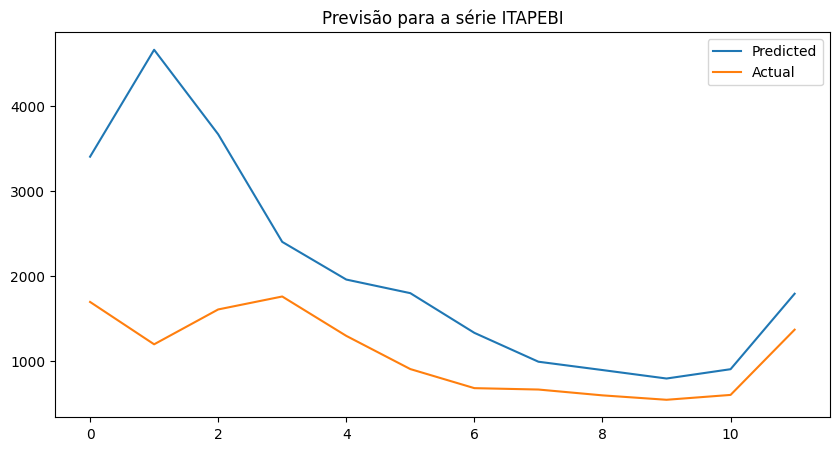

Previsão da série ITAPEBI: [3405.2632  4665.4775  3669.7173  2401.3203  1957.2292  1796.7773
 1328.9863   988.66974  890.4839   790.7288   900.5825  1790.0791 ]
Treinando para a série: PEDRA DO CAVALO
1/1 [==============================] - 1s 653ms/step
Predicted next 12 values: [ 823.6868  1430.7437  2353.0522  2294.2717  1410.1986  1612.9661
 2018.7656  1623.3711  1216.8386  1009.3865  1207.6014  1016.50366]


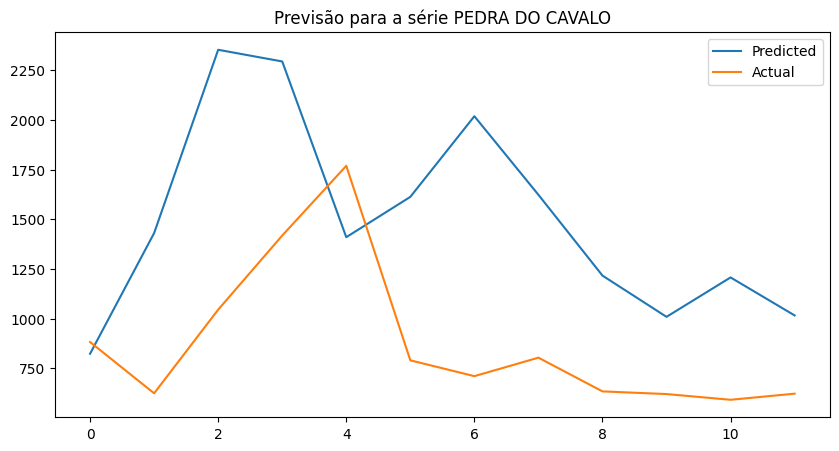

Previsão da série PEDRA DO CAVALO: [ 823.6868  1430.7437  2353.0522  2294.2717  1410.1986  1612.9661
 2018.7656  1623.3711  1216.8386  1009.3865  1207.6014  1016.50366]
Treinando para a série: BOA ESPERANÇA
1/1 [==============================] - 1s 659ms/step
Predicted next 12 values: [2665.081   3902.9592  4878.6724  5526.353   5216.4233  3848.6184
 2201.4558  1276.7985  1008.13983  952.2101  1109.6713  1803.8839 ]


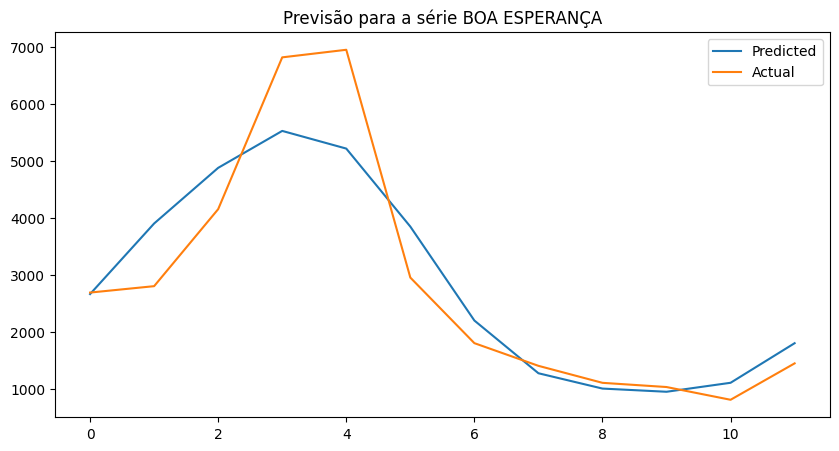

Previsão da série BOA ESPERANÇA: [2665.081   3902.9592  4878.6724  5526.353   5216.4233  3848.6184
 2201.4558  1276.7985  1008.13983  952.2101  1109.6713  1803.8839 ]
Treinando para a série: SOBRADINHO
1/1 [==============================] - 1s 645ms/step
Predicted next 12 values: [1895.7365  3741.3118  4198.501   3517.9526  2463.5693  1644.3555
 1372.523   1175.4456   822.4179   878.84875 1408.2832  2506.4617 ]


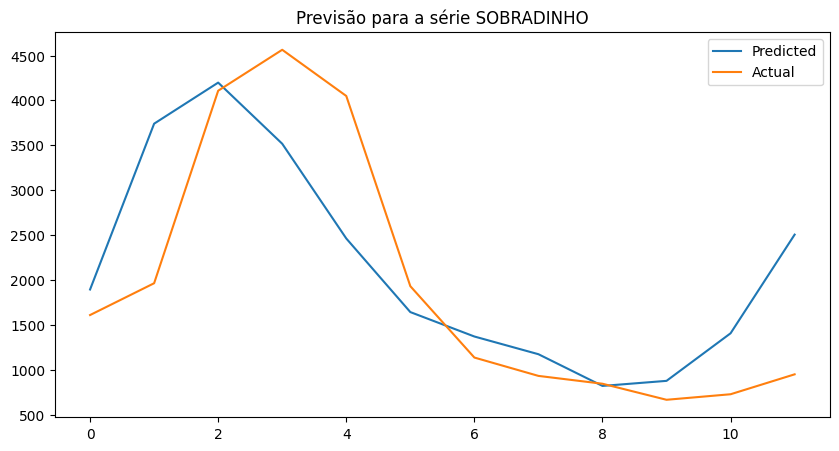

Previsão da série SOBRADINHO: [1895.7365  3741.3118  4198.501   3517.9526  2463.5693  1644.3555
 1372.523   1175.4456   822.4179   878.84875 1408.2832  2506.4617 ]
Treinando para a série: ITAPARICA
1/1 [==============================] - 1s 659ms/step
Predicted next 12 values: [1908.4427 3504.626  4100.52   3588.1702 2641.7744 1810.5776 1452.7354
 1166.1887  924.2032  823.8829 1035.7479 1984.5298]


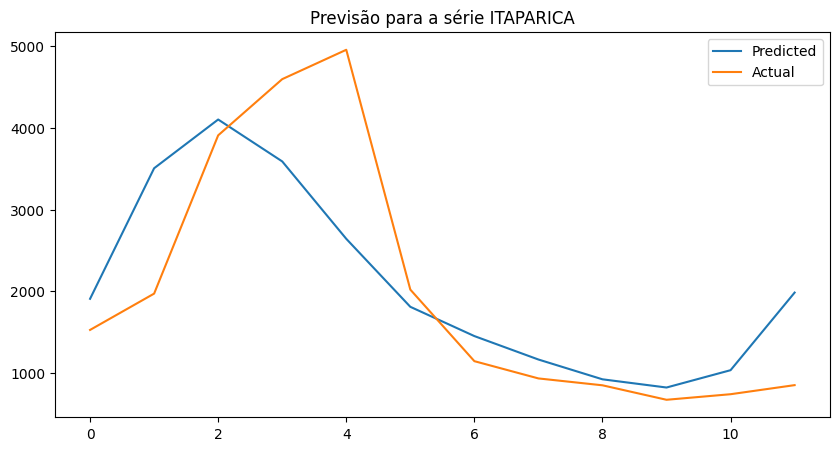

Previsão da série ITAPARICA: [1908.4427 3504.626  4100.52   3588.1702 2641.7744 1810.5776 1452.7354
 1166.1887  924.2032  823.8829 1035.7479 1984.5298]


In [117]:
for serie in X_train_dict.keys():
    print(f"Treinando para a série: {serie}")
    
    # Prepare os dados de treino e teste
    X_train = X_train_dict[serie]
    X_test = X_test_dict[serie]
    y_train = y_train_dict[serie]
    y_test = y_test_dict[serie]
    
    # Criar e treinar o modelo para a série
    model = lstm_model(time_steps=12)
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)
    
    last_input = X_test[-1].reshape(1, time_steps, 1)
    predicted_scaled = model.predict(last_input) # 12 meses

    # Inverse transform the predictions
    predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))

    print("Predicted next 12 values:", predicted.flatten())

    plt.figure(figsize=(10, 5))
    plt.plot(predicted, label="Predicted")
    plt.plot(scaler.inverse_transform(y_test[-1].reshape(-1, 1)), label="Actual")
    plt.title(f"Previsão para a série {serie}")
    plt.legend()
    plt.savefig(f'results/lstm_{serie}.png', bbox_inches='tight')
    plt.show()

    print(f"Previsão da série {serie}: {predicted.flatten()}")
